# Interurban Migration Analysis Based on Gravity Model and Machine Learning: A Case Study of Hainan Free Trade Port

#### This dissertation is submitted in part requirement for the MSc in the Centre for Advanced Spatial Analysis,Bartlett Faculty of the Build Environment, UCL.
### Author:Tiannan Ge
### Student ID: 22124399
### Supervised by Prof. Michael Batty
#### CASA0004 for MSc Dissertation | 24 August 2023 

### Tip: If a library is not installed, please pip install the package first.

### Remarks: SFP - Spring Festival period, OP - Ordinary Period, WP - Whole Period

In [3]:
pip install pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 5.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24554 sha256=fd76438283d3727dd28111878a2754a28a3001b03acf55857f4b65159ac9d0e4
  Stored in directory: /home/jovyan/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import matplotlib.colors as colors
import numpy as np
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
#import numpy as npimport sys
import sklearn
import xgboost
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import graphviz
import re

from ChineseAdminiDivisionsDict import CitiesCode, ProvinceCode
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.patches import Circle

print("xgboost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)
print(sys.version)

xgboost version: 1.6.2
scikit-learn version: 1.1.1
3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]


# Data loading and cleansing

### Loading Hainan vector map

In [7]:
file = "./Data/hainan_shp/hainan.shp"
Hainan_shp = gpd.read_file(file)
Hainan_shp

Name  Shape_Leng  Shape_Area    code  \
0       Haikou    2.961516    0.176305  460100   
1     Tunchang    1.871136    0.107343  469022   
2     Wenchang    4.118149    0.204150  469005   
3     Chengmai    3.576838    0.178915  469023   
4       Dingan    2.188567    0.101014  469021   
5      Danzhou    5.005313    0.282965  460400   
6       Lingao    2.167093    0.111865  469024   
7      Wanning    2.822745    0.166586  469006   
8     Qionghai    2.279246    0.144442  469002   
9       Ledong    2.428217    0.232230  469027   
10   Wuzhishan    2.472898    0.200723  469001   
11  Qiongzhong    2.829065    0.231219  469030   
12      Baisha    2.373066    0.181162  469025   
13  Changjiang    2.541158    0.137800  469026   
14    Dongfang    2.435048    0.194319  469007   
15    Lingshui    2.234924    0.094933  469028   
16       Sanya    3.822298    0.160752  460200   
17     Baoting    2.472898    0.200723  469029   

                                             geometry  
0   POLYGON Z ((110.37209 20.08486 0.00000, 110.37...  
1   POLYGON Z ((110.13223 19.56403 0.00000, 110.14...  
2   POLYGON Z ((110.68819 20.16264 0.00000, 110.68...  
3   POLYGON Z ((110.15691 19.97214 0.00000, 110.15...  
4   POLYGON Z ((110.52322 19.56573 0.00000, 110.51...  
5   POLYGON Z ((109.30653 19.91847 0.00000, 109.30...  
6   POLYGON Z ((109.70875 20.01625 0.00000, 109.70...  
7   POLYGON Z ((110.56709 19.13347 0.00000, 110.56...  
8   POLYGON Z ((110.51385 19.46926 0.00000, 110.52...  
9   POLYGON Z ((109.11622 18.87419 0.00000, 109.12...  
10  POLYGON Z ((109.71238 18.83534 0.00000, 109.71...  
11  POLYGON Z ((109.86682 19.39124 0.00000, 109.86...  
12  POLYGON Z ((109.67790 19.18400 0.00000, 109.68...  
13  POLYGON Z ((108.93320 19.50820 0.00000, 108.93...  
14  POLYGON Z ((108.65347 19.31185 0.00000, 108.65...  
15  POLYGON Z ((109.82581 18.72831 0.00000, 109.83...  
16  POLYGON Z ((109.41927 18.56391 0.00000, 109.42...  
17  POLYGON Z ((109.71238 18.83534 0.00000, 109.70...

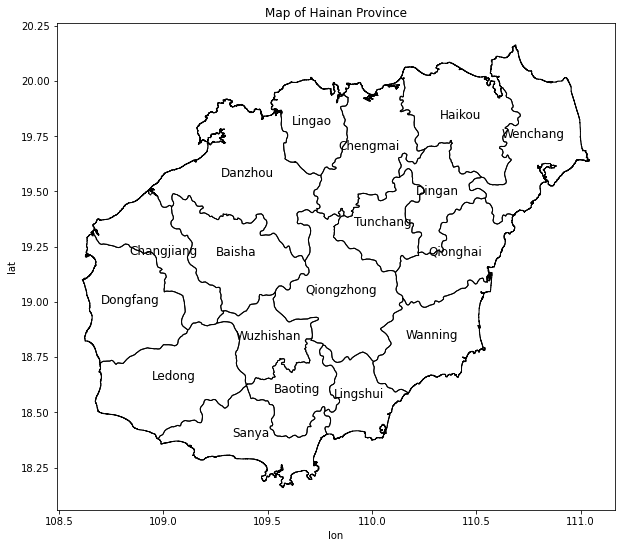

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# Mapping the Hainan Province
Hainan_shp.plot(ax=ax, facecolor="None", edgecolor="black")

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, city_name, fontsize=12, ha='center')

# Setting the title and axes of a graph
ax.set_title('Map of Hainan Province')
ax.set_xlabel('lon')
ax.set_ylabel('lat')

plt.show()

### projector

In [9]:
print(Hainan_shp.crs)
Hainan_shp = Hainan_shp.to_crs(epsg=3857)
print(Hainan_shp.crs)

epsg:4326
epsg:3857


### Sort by code and take the center point

In [10]:
#Important step, sort by area code, default ascending order (smallest to largest)
Hainan_shp.sort_values(by=["code"], inplace = True)
#extract the centroids
Hainan_shp["Centroids"] =Hainan_shp.geometry.centroid

### Count the distance between the centers of mass of the cities

In [11]:
Hainan_shp.set_index('code', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids
distances = Hainan_shp.rename_axis('Orig').Centroids.apply(lambda x:Hainan_shp.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
#Change the column name of column 0 of distances, a DataFrame, to 'Dist' and modify it on the original DataFrame.
distances.rename(columns = {0:'Dist'}, inplace=True)
#The "Orig" column represents the number of the original geographic location and the "Dest" column represents the number of the target geographic location. Sorting is done first by origin and then by destination.
distances.sort_values(by=["Orig", "Dest"], inplace = True)
#Resets the index of the DataFrame 'London' to the default integer index.
Hainan_shp.reset_index(inplace=True)
print(distances)

       Orig    Dest           Dist
0    460100  460100       0.000000
1    460100  460200  203320.263286
2    460100  460400  118177.325704
3    460100  469001  156499.101361
4    460100  469002   73466.054328
..      ...     ...            ...
319  469030  469026   97012.777254
320  469030  469027  100153.928500
321  469030  469028   55753.655131
322  469030  469029   57346.520012
323  469030  469030       0.000000

[324 rows x 3 columns]


### Loading socio-economic indicators 

In [13]:
current_path = os.getcwd()
df = pd.read_excel(current_path + '/Data/social_indicators.xlsx')
# Converting data to dataframes
social_indicators = pd.DataFrame(df)
social_indicators

name    code  population  GDP_growth_rate  tertiary_industry_rate  \
0       Haikou  460100      290.80            44.74                    79.0   
1        Sanya  460200      105.61            52.97                    73.9   
2      Danzhou  460400       97.01            56.59                    53.8   
3    Wuzhishan  469001       11.21            30.69                    62.2   
4     Wenchang  469005       56.72            49.33                    43.8   
5     Qionghai  469002       53.46            39.41                    53.9   
6      Wanning  469006       55.30            33.41                    46.5   
7       Dingan  469021       28.79            30.17                    49.2   
8     Tunchang  469022       25.54            37.36                    54.7   
9     Chengmai  469023       50.33            37.79                    56.0   
10      Ledong  469024       46.93            43.47                    33.2   
11    Dongfang  469007       44.98            36.30                    36.3   
12      Lingao  469027       42.26            27.45                    32.9   
13  Qiongzhong  469030       18.12            37.99                    49.6   
14     Baoting  469029       15.73            37.26                    54.4   
15    Lingshui  469028       37.60            46.26                    58.9   
16      Baisha  469025       16.43            32.06                    49.2   
17  Changjiang  469026       23.41            25.14                    32.5   

    per_capita_income  ave_house_prices  per_capita_green  
0               38129             15825              13.6  
1               37762             31247              16.3  
2               28514              7934               9.6  
3               26134             11695               6.5  
4               29471             12103               8.8  
5               29241             14135               9.6  
6               27988             15685              10.3  
7               25215             10282              12.3  
8               25621              7793               1.9  
9               29194             12476               2.3  
10              23224             15024               4.3  
11              27641             10954               4.1  
12              24096              8214               8.0  
13              23243              7367               9.7  
14              23446             17496              14.7  
15              25565             29911               7.1  
16              22477              7966               8.7  
17              29818              8364               8.9

### Defining the SFP working path

In [14]:
#New Merge Storage Path-SFP
path = f'Data/Flow/202301-02/merge'

if not os.path.exists(path):
    os.makedirs(path)
    
# Defining input and output paths
input_path = current_path + '/Data/Flow/202301-02/'
output_path = current_path + '/' + path

### Processing SFP traffic data

### Load xls file, merge to csv by city

In [15]:
# Get all xls files
file_list = [f for f in os.listdir(input_path) if f.endswith('.xls')]

# Iterate through each file and merge them into a dictionary
data_dict = {}
for file_name in file_list:
    # Parsing filenames for city name, type and date
    city, data_type, _ = file_name[:-4].split('-')
    # Read files and group them by city code columns
    df_0102 = pd.read_excel(os.path.join(input_path, file_name))
    # Consolidation of data based on city codes
    key = f'{city}-{data_type}'
    if key not in data_dict:
        data_dict[key] = df_0102
    else:
        data_dict[key] = pd.merge(data_dict[key], df_0102, on='城市代码')

# Save the data in the dictionary as a csv file
for key, df_0102 in data_dict.items():
    df_0102.columns = df_0102.columns.astype(str)
    df_0102 = df_0102.drop([col for col in df_0102.columns if '_y' in col], axis=1)
    df_0102.columns = [col.replace('_x', '') if col.endswith('_x') and idx!=0 else col for idx, col in enumerate(df_0102.columns)]
    file_name = f'{key}.csv'
    df_0102.to_csv(os.path.join(output_path, file_name), encoding='gbk',index=False)

### Extract cities in Hainan Province, excluding Sansha City

In [16]:
# Get all csv files
file_list = [f for f in os.listdir(output_path) if f.endswith('.csv')]

# Iterate through each file, filtering out lines where the city code begins with '46'
for file_name in file_list:
    # Read file
    df_0102 = pd.read_csv(os.path.join(output_path, file_name), encoding='gbk',dtype=str)
    # Filter out rows with city code starting with '46' and delete Sansha City
    df_0102 = df_0102[df_0102['城市代码'].str.startswith('46')]
    df_0102 = df_0102.drop(df_0102[df_0102['城市代码'] == '460300'].index, axis=0)
    # Overwrite the original file with the results
    df_0102.to_csv(os.path.join(output_path, file_name), encoding='gbk', index=False)

### Insert city and code of origin and destination to count total flows

In [17]:
from ChineseAdminiDivisionsDict import CitiesCode, ProvinceCode
for file_name in file_list:
    df_0102 = pd.read_csv(os.path.join(output_path, file_name), encoding='gbk')
    city_name = file_name.split('-')[0]
    city_code = CitiesCode.get(city_name)
    df_0102.insert(0, "Orig_code", city_code)
    df_0102.insert(0, "Orig_name", city_name)
    df_0102['Orig_code'] = city_code
    df_0102['Orig_name'] = city_name
    df_0102['Total_flow'] = df_0102.iloc[:, 4:].sum(axis=1)
    df_0102 = df_0102.rename(columns={'城市代码': 'Dest_code', '迁出目的地': 'Dest_name'})
    df_0102.to_csv(os.path.join(output_path, file_name), encoding='gbk', index=False)

### Merge all csv files into dataframe df_0102 (SFP) and sort by start/end code

In [18]:
# Merge all csv files into one DataFrame
df_0102 = pd.concat([pd.read_csv(os.path.join(output_path, f), encoding='gbk') for f in file_list])
#df_0102 = df_0102[df_0102['Total_flow'] != 0]
#Delete days that do not exist in February
df_0102.drop(['20230229', '20230230', '20230231'], axis=1, inplace=True)
#sort
df_0102.sort_values(by=["Orig_code", "Dest_code"], inplace = True)
# Save the merged DataFrame as a csv file
#df_0102.to_csv(os.path.join(mod_path, "merged.csv"), encoding='gbk', index=False)

### Excluding intra-city flows (origin equals destination)

In [19]:
distances = distances[distances["Orig"] != distances["Dest"]]
df_0102 = df_0102[df_0102["Orig_code"] != df_0102["Dest_code"]]

### Consolidation of distances to flow tables

In [20]:
df_0102 = df_0102.merge(distances[['Orig','Dest','Dist']], left_on=['Orig_code', 'Dest_code'], right_on=['Orig', 'Dest'], how='left')

In [21]:
df_0102.sort_values(by=["Orig_code", "Dest_code"], inplace = True)

### Calculate total SFP flows

In [22]:
df_0102["TotalNoIntra"] = df_0102.apply(lambda x: 0 if x['Orig_code'] == x['Dest_code'] else x['Total_flow'], axis=1)

In [23]:
df_0102["offset"]= df_0102.apply(lambda x: 0.0000000001 if x['Orig_code'] == x['Dest_code'] else 0, axis=1)

In [24]:
#This code puts the first three columns at the top
beg = ["Orig_code", "Dest_code", "TotalNoIntra"] 
cols = beg + [col for col in df_0102.columns.tolist() if col not in beg]
df_0102 = df_0102.reindex(columns = cols)

### Change the name of the city to English

In [25]:
df_0102['Orig_name'] = df_0102['Orig_name'].replace({'海口市': 'Haikou', '三亚市': 'Sanya', '白沙黎族自治县': 'Baisha', '保亭黎族苗族自治县': 'Baoting', '昌江黎族自治县': 'Changjiang', '澄迈县': 'Chengmai', '儋州市': 'Danzhou', '定安县': 'Dingan', '东方市': 'Dongfang', '乐东黎族自治县': 'Ledong', '临高县': 'Lingao', '陵水黎族自治县': 'Lingshui', '琼海市': 'Qionghai', '琼中黎族苗族自治县': 'Qiongzhong', '屯昌县': 'Tunchang', '万宁市': 'Wanning', '文昌市': 'Wenchang', '五指山市': 'Wuzhishan'})
df_0102['Dest_name'] = df_0102['Dest_name'].replace({'海口市': 'Haikou', '三亚市': 'Sanya', '白沙黎族自治县': 'Baisha', '保亭黎族苗族自治县': 'Baoting', '昌江黎族自治县': 'Changjiang', '澄迈县': 'Chengmai', '儋州市': 'Danzhou', '定安县': 'Dingan', '东方市': 'Dongfang', '乐东黎族自治县': 'Ledong', '临高县': 'Lingao', '陵水黎族自治县': 'Lingshui', '琼海市': 'Qionghai', '琼中黎族苗族自治县': 'Qiongzhong', '屯昌县': 'Tunchang', '万宁市': 'Wanning', '文昌市': 'Wenchang', '五指山市': 'Wuzhishan'})

### Integration of df_0102 (SFP) into socio-economic indicators

In [26]:
df_0102 = pd.merge(df_0102, social_indicators, left_on='Orig_name', right_on='name', how='left', suffixes=('_Orig','_Dest'))
df_0102 = pd.merge(df_0102, social_indicators, left_on='Dest_name', right_on='name', how='left', suffixes=('_Orig','_Dest'))

In [27]:
df_0102 = df_0102.drop(['Orig', 'Dest','name_Orig','code_Orig','name_Dest','code_Dest'], axis=1)

In [28]:
df_0102

Orig_code  Dest_code  TotalNoIntra   Orig_name   Dest_name  20230101  \
0       460100     460200        468.32      Haikou       Sanya      6.97   
1       460100     460400        424.57      Haikou     Danzhou      8.82   
2       460100     469001         42.95      Haikou   Wuzhishan      0.59   
3       460100     469002        288.17      Haikou    Qionghai      4.77   
4       460100     469005        675.44      Haikou    Wenchang     10.69   
..         ...        ...           ...         ...         ...       ...   
301     469030     469025         86.71  Qiongzhong      Baisha      2.79   
302     469030     469026         39.36  Qiongzhong  Changjiang      0.76   
303     469030     469027        124.76  Qiongzhong      Ledong      1.92   
304     469030     469028        186.28  Qiongzhong    Lingshui      3.07   
305     469030     469029         92.92  Qiongzhong     Baoting      1.81   

     20230102  20230103  20230104  20230105  ...  tertiary_industry_rate_Orig  \
0        7.84      8.78      8.29      7.84  ...                         79.0   
1        7.10      7.80      7.01      6.80  ...                         79.0   
2        0.70      0.87      0.71      0.61  ...                         79.0   
3        4.20      4.11      4.00      3.85  ...                         79.0   
4        9.42      9.59      9.11      9.18  ...                         79.0   
..        ...       ...       ...       ...  ...                          ...   
301      2.20      2.17      1.99      1.75  ...                         49.6   
302      1.21      0.69      0.17      0.68  ...                         49.6   
303      2.53      2.22      2.34      2.43  ...                         49.6   
304      1.54      2.07      2.63      2.09  ...                         49.6   
305      0.99      1.85      1.46      1.36  ...                         49.6   

     per_capita_income_Orig  ave_house_prices_Orig  per_capita_green_Orig  \
0                     38129                  15825                   13.6   
1                     38129                  15825                   13.6   
2                     38129                  15825                   13.6   
3                     38129                  15825                   13.6   
4                     38129                  15825                   13.6   
..                      ...                    ...                    ...   
301                   23243                   7367                    9.7   
302                   23243                   7367                    9.7   
303                   23243                   7367                    9.7   
304                   23243                   7367                    9.7   
305                   23243                   7367                    9.7   

     population_Dest  GDP_growth_rate_Dest  tertiary_industry_rate_Dest  \
0             105.61                 52.97                         73.9   
1              97.01                 56.59                         53.8   
2              11.21                 30.69                         62.2   
3              53.46                 39.41                         53.9   
4              56.72                 49.33                         43.8   
..               ...                   ...                          ...   
301            16.43                 32.06                         49.2   
302            23.41                 25.14                         32.5   
303            46.93                 43.47                         33.2   
304            37.60                 46.26                         58.9   
305            15.73                 37.26                         54.4   

     per_capita_income_Dest  ave_house_prices_Dest  per_capita_green_Dest  
0                     37762                  31247                   16.3  
1                     28514                   7934                    9.6  
2                     26134                  11695   

### Processing of OP flow data

### Defining OP work paths

In [29]:
#New merge storage path
path = f'Data/Flow/202303-04/merge'

if not os.path.exists(path):
    os.makedirs(path)

# Define input and output paths
input_path = current_path + '/Data/Flow/202303-04/'
output_path = current_path + '/' + path

### Load xls file, merge to csv by city, the following processing steps are the same as SFP.

In [30]:
# Get all xls files
file_list = [f for f in os.listdir(input_path) if f.endswith('.xls')]

# Iterate through each file and merge them into a dictionary
data_dict = {}
for file_name in file_list:
    # Parsing filenames for city name, type and date
    city, data_type, _ = file_name[:-4].split('-')
    # Read files and group them by city code columns
    df_0304 = pd.read_excel(os.path.join(input_path, file_name))
    # Consolidation of data based on city codes
    key = f'{city}-{data_type}'
    if key not in data_dict:
        data_dict[key] = df_0304
    else:
        data_dict[key] = pd.merge(data_dict[key], df_0304, on='城市代码')

# Save the data in the dictionary as a csv file
for key, df_0304 in data_dict.items():
    df_0304.columns = df_0304.columns.astype(str)
    df_0304 = df_0304.drop([col for col in df_0304.columns if '_y' in col], axis=1)
    df_0304.columns = [col.replace('_x', '') if col.endswith('_x') and idx!=0 else col for idx, col in enumerate(df_0304.columns)]
    file_name = f'{key}.csv'
    df_0304.to_csv(os.path.join(output_path, file_name), encoding='gbk',index=False)


In [31]:
# Get all csv files
file_list = [f for f in os.listdir(output_path) if f.endswith('.csv')]

# Iterate through each file, filtering out lines where the city code begins with '46'
for file_name in file_list:
    # Read file
    df_0304 = pd.read_csv(os.path.join(output_path, file_name), encoding='gbk',dtype=str)
    # Filter out rows with city code starting with '46'
    df_0304 = df_0304[df_0304['城市代码'].str.startswith('46')]
    df_0304 = df_0304.drop(df_0304[df_0304['城市代码'] == '460300'].index, axis=0)
    # Overwrite the original file with the results
    df_0304.to_csv(os.path.join(output_path, file_name), encoding='gbk', index=False)

In [32]:
for file_name in file_list:
    df_0304 = pd.read_csv(os.path.join(output_path, file_name), encoding='gbk')
    city_name = file_name.split('-')[0]
    city_code = CitiesCode.get(city_name)
    df_0304.insert(0, "Orig_code", city_code)
    df_0304.insert(0, "Orig_name", city_name)
    df_0304['Orig_code'] = city_code
    df_0304['Orig_name'] = city_name
    df_0304['Total_flow'] = df_0304.iloc[:, 4:].sum(axis=1)
    df_0304 = df_0304.rename(columns={'城市代码': 'Dest_code', '迁出目的地': 'Dest_name'})
    df_0304.to_csv(os.path.join(output_path, file_name), encoding='gbk', index=False)

In [33]:
# Merge all csv files into one DataFrame
df_0304 = pd.concat([pd.read_csv(os.path.join(output_path, f), encoding='gbk') for f in file_list])
#df_0102 = df_0102[df_0102['Total_flow'] != 0]
#Delete days that do not exist in April
df_0304.drop(['20230431'], axis=1, inplace=True)
#sort
df_0304.sort_values(by=["Orig_code", "Dest_code"], inplace = True)
# Save the merged DataFrame as a csv file
#df_0102.to_csv(os.path.join(mod_path, "merged.csv"), encoding='gbk', index=False)

In [34]:
df_0304 = df_0304.merge(distances[['Orig','Dest','Dist']], left_on=['Orig_code', 'Dest_code'], right_on=['Orig', 'Dest'], how='left')

In [35]:
df_0304.sort_values(by=["Orig_code", "Dest_code"], inplace = True)

In [36]:
df_0304["TotalNoIntra"] = df_0304.apply(lambda x: 0 if x['Orig_code'] == x['Dest_code'] else x['Total_flow'], axis=1)

In [37]:
df_0304["offset"]= df_0304.apply(lambda x: 0.0000000001 if x['Orig_code'] == x['Dest_code'] else 0, axis=1)

In [38]:
df_0304 = df_0304[df_0304["Orig_code"] != df_0304["Dest_code"]]

In [39]:
beg = ["Orig_code", "Dest_code", "TotalNoIntra"] 
cols = beg + [col for col in df_0304.columns.tolist() if col not in beg]
df_0304 = df_0304.reindex(columns = cols)

In [40]:
df_0304['Orig_name'] = df_0304['Orig_name'].replace({'海口市': 'Haikou', '三亚市': 'Sanya', '白沙黎族自治县': 'Baisha', '保亭黎族苗族自治县': 'Baoting', '昌江黎族自治县': 'Changjiang', '澄迈县': 'Chengmai', '儋州市': 'Danzhou', '定安县': 'Dingan', '东方市': 'Dongfang', '乐东黎族自治县': 'Ledong', '临高县': 'Lingao', '陵水黎族自治县': 'Lingshui', '琼海市': 'Qionghai', '琼中黎族苗族自治县': 'Qiongzhong', '屯昌县': 'Tunchang', '万宁市': 'Wanning', '文昌市': 'Wenchang', '五指山市': 'Wuzhishan'})
df_0304['Dest_name'] = df_0304['Dest_name'].replace({'海口市': 'Haikou', '三亚市': 'Sanya', '白沙黎族自治县': 'Baisha', '保亭黎族苗族自治县': 'Baoting', '昌江黎族自治县': 'Changjiang', '澄迈县': 'Chengmai', '儋州市': 'Danzhou', '定安县': 'Dingan', '东方市': 'Dongfang', '乐东黎族自治县': 'Ledong', '临高县': 'Lingao', '陵水黎族自治县': 'Lingshui', '琼海市': 'Qionghai', '琼中黎族苗族自治县': 'Qiongzhong', '屯昌县': 'Tunchang', '万宁市': 'Wanning', '文昌市': 'Wenchang', '五指山市': 'Wuzhishan'})

In [41]:
# Merging Data Frames
df_0304 = pd.merge(df_0304, social_indicators, left_on='Orig_name', right_on='name', how='left', suffixes=('_Orig','_Dest'))
df_0304 = pd.merge(df_0304, social_indicators, left_on='Dest_name', right_on='name', how='left', suffixes=('_Orig','_Dest'))
df_0304 = df_0304.drop(['Orig', 'Dest','name_Orig','code_Orig','name_Dest','code_Dest'], axis=1)
df_0304

Orig_code  Dest_code  TotalNoIntra   Orig_name   Dest_name  20230301  \
0       460100     460200        484.70      Haikou       Sanya      8.49   
1       460100     460400        440.54      Haikou     Danzhou      7.09   
2       460100     469001         50.41      Haikou   Wuzhishan      0.71   
3       460100     469002        326.83      Haikou    Qionghai      5.73   
4       460100     469005        675.60      Haikou    Wenchang     10.76   
..         ...        ...           ...         ...         ...       ...   
301     469030     469025         94.93  Qiongzhong      Baisha      2.43   
302     469030     469026         37.33  Qiongzhong  Changjiang      1.07   
303     469030     469027        139.20  Qiongzhong      Ledong      1.52   
304     469030     469028        169.15  Qiongzhong    Lingshui      3.75   
305     469030     469029         90.82  Qiongzhong     Baoting      1.19   

     20230302  20230303  20230304  20230305  ...  tertiary_industry_rate_Orig  \
0        8.27      7.42      6.70      7.15  ...                         79.0   
1        6.04      6.28      6.26      6.27  ...                         79.0   
2        0.62      0.62      0.63      0.71  ...                         79.0   
3        5.09      5.58      7.50      6.13  ...                         79.0   
4       10.06     10.72     15.10     13.12  ...                         79.0   
..        ...       ...       ...       ...  ...                          ...   
301      1.65      1.50      0.67      1.26  ...                         49.6   
302      0.74      0.61      1.24      0.46  ...                         49.6   
303      1.48      2.29      1.30      2.03  ...                         49.6   
304      1.78      2.93      2.64      2.73  ...                         49.6   
305      0.87      2.81      0.96      1.33  ...                         49.6   

     per_capita_income_Orig  ave_house_prices_Orig  per_capita_green_Orig  \
0                     38129                  15825                   13.6   
1                     38129                  15825                   13.6   
2                     38129                  15825                   13.6   
3                     38129                  15825                   13.6   
4                     38129                  15825                   13.6   
..                      ...                    ...                    ...   
301                   23243                   7367                    9.7   
302                   23243                   7367                    9.7   
303                   23243                   7367                    9.7   
304                   23243                   7367                    9.7   
305                   23243                   7367                    9.7   

     population_Dest  GDP_growth_rate_Dest  tertiary_industry_rate_Dest  \
0             105.61                 52.97                         73.9   
1              97.01                 56.59                         53.8   
2              11.21                 30.69                         62.2   
3              53.46                 39.41                         53.9   
4              56.72                 49.33                         43.8   
..               ...                   ...                          ...   
301            16.43                 32.06                         49.2   
302            23.41                 25.14                         32.5   
303            46.93                 43.47                         33.2   
304            37.60                 46.26                         58.9   
305            15.73                 37.26                         54.4   

     per_capita_income_Dest  ave_house_prices_Dest  per_capita_green_Dest  
0                     37762                  31247                   16.3  
1                     28514                   7934                    9.6  
2                     26134                  11695   

### Combine all months as Whole Period (WP)

In [42]:
dates = [col for col in df_0304.columns if re.match("^\d+$", col) is not None]

In [43]:
df_0304_selected = df_0304[['Orig_code', 'Dest_code'] + dates + ['TotalNoIntra']]

In [44]:
merged_df = pd.merge(df_0102, df_0304_selected, on=['Orig_code', 'Dest_code'], how='left')

In [45]:
merged_df = merged_df.rename(columns={'TotalNoIntra_x': 'TotalNoIntra_0102', 'TotalNoIntra_y': 'TotalNoIntra_0304'})

In [46]:
merged_df['TotalNoIntra'] = merged_df['TotalNoIntra_0102'] + merged_df['TotalNoIntra_0304']

In [47]:
merged_df.to_csv('merged_df.csv', index=False)

In [48]:
merged_df

Orig_code  Dest_code  TotalNoIntra_0102   Orig_name   Dest_name  \
0       460100     460200             468.32      Haikou       Sanya   
1       460100     460400             424.57      Haikou     Danzhou   
2       460100     469001              42.95      Haikou   Wuzhishan   
3       460100     469002             288.17      Haikou    Qionghai   
4       460100     469005             675.44      Haikou    Wenchang   
..         ...        ...                ...         ...         ...   
301     469030     469025              86.71  Qiongzhong      Baisha   
302     469030     469026              39.36  Qiongzhong  Changjiang   
303     469030     469027             124.76  Qiongzhong      Ledong   
304     469030     469028             186.28  Qiongzhong    Lingshui   
305     469030     469029              92.92  Qiongzhong     Baoting   

     20230101  20230102  20230103  20230104  20230105  ...  20230423  \
0        6.97      7.84      8.78      8.29      7.84  ...      7.91   
1        8.82      7.10      7.80      7.01      6.80  ...      7.74   
2        0.59      0.70      0.87      0.71      0.61  ...      1.20   
3        4.77      4.20      4.11      4.00      3.85  ...      4.59   
4       10.69      9.42      9.59      9.11      9.18  ...     10.39   
..        ...       ...       ...       ...       ...  ...       ...   
301      2.79      2.20      2.17      1.99      1.75  ...      1.33   
302      0.76      1.21      0.69      0.17      0.68  ...      0.48   
303      1.92      2.53      2.22      2.34      2.43  ...      2.09   
304      3.07      1.54      2.07      2.63      2.09  ...      2.17   
305      1.81      0.99      1.85      1.46      1.36  ...      0.87   

     20230424  20230425  20230426  20230427  20230428  20230429  20230430  \
0        9.30      9.09      8.35      8.06      6.65      6.21      6.93   
1        7.19      6.54      6.45      6.48      8.10      9.37      8.85   
2        1.01      0.92      0.86      0.69      0.82      1.33      1.46   
3        4.62      4.68      4.19      4.18      5.02      6.61      6.91   
4       10.02     10.08     10.56     10.48     10.65     13.29     14.31   
..        ...       ...       ...       ...       ...       ...       ...   
301      1.81      1.97      2.43      1.54      1.18      1.23      0.91   
302      0.35      0.25      0.17      0.42      0.94      0.73      0.89   
303      1.99      2.18      2.39      2.15      1.89      2.28      2.10   
304      1.95      2.05      2.34      2.05      2.67      3.73      4.74   
305      1.99      1.32      0.86      1.49      1.22      1.39      1.18   

     TotalNoIntra_0304  TotalNoIntra  
0               484.70        953.02  
1               440.54        865.11  
2                50.41         93.36  
3               326.83        615.00  
4               675.60       1351.04  
..                 ...           ...  
301              94.93        181.64  
302              37.33         76.69  
303             139.20        263.96  
304             169.15        355.43  
305              90.82        183.74  

[306 rows x 142 columns]

# Descriptive Statistics

### SFP, ranking of urban inflows

In [49]:
df_0102_totalflow_dest = df_0102.groupby('Dest_name')['TotalNoIntra'].sum().reset_index()
df_0102_totalflow_dest = df_0102_totalflow_dest.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)['Orig_name'].tolist()
df_0102_totalflow_dest

Dest_name  TotalNoIntra
7       Haikou      32511.84
13       Sanya      15616.66
4      Danzhou       7022.05
10    Lingshui       4162.37
15     Wanning       4008.24
3     Chengmai       3692.01
11    Qionghai       3395.92
8       Ledong       3121.36
6     Dongfang       2842.69
16    Wenchang       2693.68
2   Changjiang       2294.55
5       Dingan       2046.08
14    Tunchang       1889.55
1      Baoting       1814.92
9       Lingao       1714.43
12  Qiongzhong       1479.14
17   Wuzhishan       1361.33
0       Baisha       1150.98

### SFP, urban outflow ranking

In [50]:
df_0102_totalflow_orig = df_0102.groupby('Orig_name')['TotalNoIntra'].sum().reset_index()
df_0102_totalflow_orig = df_0102_totalflow_orig.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)和['Orig_name'].tolist()
df_0102_totalflow_orig

Orig_name  TotalNoIntra
5       Dingan       5563.72
14    Tunchang       5560.80
12  Qiongzhong       5517.90
0       Baisha       5461.54
17   Wuzhishan       5390.08
9       Lingao       5378.08
1      Baoting       5356.61
3     Chengmai       5327.22
2   Changjiang       5314.05
8       Ledong       5285.88
6     Dongfang       5185.74
16    Wenchang       5153.43
15     Wanning       5105.08
4      Danzhou       5057.04
11    Qionghai       4932.55
10    Lingshui       4891.10
7       Haikou       4572.32
13       Sanya       3764.66

### OP,Ranking of urban inflows

In [51]:
df_0304_totalflow_dest = df_0304.groupby('Dest_name')['TotalNoIntra'].sum().reset_index()
df_0304_totalflow_dest = df_0304_totalflow_dest.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)['Orig_name'].tolist()
df_0304_totalflow_dest

Dest_name  TotalNoIntra
7       Haikou      35004.79
13       Sanya      14284.06
4      Danzhou       7090.46
3     Chengmai       3937.49
15     Wanning       3673.92
10    Lingshui       3653.29
11    Qionghai       3650.47
8       Ledong       3447.39
6     Dongfang       3269.32
16    Wenchang       2706.55
2   Changjiang       2433.93
14    Tunchang       2278.58
5       Dingan       2270.65
9       Lingao       1909.57
1      Baoting       1827.09
12  Qiongzhong       1800.79
17   Wuzhishan       1525.06
0       Baisha       1375.18

### OP,Ranking of urban outflows

In [52]:
df_0304_totalflow_orig = df_0304.groupby('Orig_name')['TotalNoIntra'].sum().reset_index()
df_0304_totalflow_orig = df_0304_totalflow_orig.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)和['Orig_name'].tolist()
df_0304_totalflow_orig

Orig_name  TotalNoIntra
14    Tunchang       5795.23
5       Dingan       5788.61
12  Qiongzhong       5764.31
0       Baisha       5694.31
9       Lingao       5605.14
2   Changjiang       5589.27
3     Chengmai       5552.27
17   Wuzhishan       5508.31
1      Baoting       5477.91
16    Wenchang       5383.76
8       Ledong       5361.62
4      Danzhou       5335.44
15     Wanning       5270.07
6     Dongfang       5245.86
10    Lingshui       5116.48
11    Qionghai       5056.45
7       Haikou       4824.00
13       Sanya       3769.55

### WP, city inflow rankings

In [53]:
merged_df_totalflow_dest = merged_df.groupby('Dest_name')['TotalNoIntra'].sum().reset_index()
merged_df_totalflow_dest = merged_df_totalflow_dest.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)['Orig_name'].tolist()
merged_df_totalflow_dest

Dest_name  TotalNoIntra
7       Haikou      67516.63
13       Sanya      29900.72
4      Danzhou      14112.51
10    Lingshui       7815.66
15     Wanning       7682.16
3     Chengmai       7629.50
11    Qionghai       7046.39
8       Ledong       6568.75
6     Dongfang       6112.01
16    Wenchang       5400.23
2   Changjiang       4728.48
5       Dingan       4316.73
14    Tunchang       4168.13
1      Baoting       3642.01
9       Lingao       3624.00
12  Qiongzhong       3279.93
17   Wuzhishan       2886.39
0       Baisha       2526.16

### WP, urban outflow ranking

In [54]:
merged_df_totalflow_orig = merged_df.groupby('Orig_name')['TotalNoIntra'].sum().reset_index()
merged_df_totalflow_orig = merged_df_totalflow_orig.sort_values('TotalNoIntra', ascending=False)
#top_cities = df_total_flow_sorted.head(6)和['Orig_name'].tolist()
merged_df_totalflow_orig

Orig_name  TotalNoIntra
14    Tunchang      11356.03
5       Dingan      11352.33
12  Qiongzhong      11282.21
0       Baisha      11155.85
9       Lingao      10983.22
2   Changjiang      10903.32
17   Wuzhishan      10898.39
3     Chengmai      10879.49
1      Baoting      10834.52
8       Ledong      10647.50
16    Wenchang      10537.19
6     Dongfang      10431.60
4      Danzhou      10392.48
15     Wanning      10375.15
10    Lingshui      10007.58
11    Qionghai       9989.00
7       Haikou       9396.32
13       Sanya       7534.21

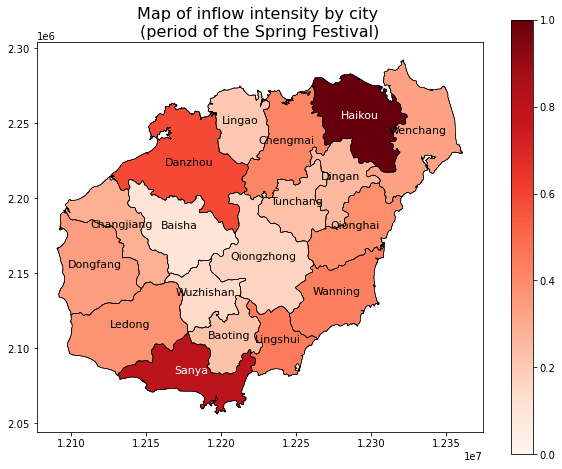

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Get sorted list of city names and list of inflows
df_0102_totalflow_dest_name = df_0102_totalflow_dest['Dest_name'].tolist()
df_0102_totalflow_dest_flows = df_0102_totalflow_dest['TotalNoIntra'].astype(int).tolist()

# Row logarithmic conversions, taking care to handle 0 values, can add a small constant to avoid negative logarithmic values
df_0102_totalflow_dest_flows_log = np.log(np.array(df_0102_totalflow_dest_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_0102_totalflow_dest_flows_norlog = scaler.fit_transform(np.array(df_0102_totalflow_dest_flows_log).reshape(-1, 1)).flatten()

# Creating a Color Level Mapping
cmap = plt.cm.get_cmap('Reds')
norm = colors.Normalize(vmin=0, vmax=1)
#norm = colors.Normalize(vmin=min(total_flows_log), vmax=max(total_flows_log))

# Mapping the logarithmic inflow sort of a city to a color scale and storing it in a new column
Hainan_shp['df_0102_totalflow_dest_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(df_0102_totalflow_dest_name, df_0102_totalflow_dest_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k')  # 绘制边界
Hainan_shp.plot(column='df_0102_totalflow_dest_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name in ['Sanya', 'Haikou']:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')

# Setting the map title and color bar labels
ax.set_title('Map of inflow intensity by city \n(period of the Spring Festival)', fontsize=16)

# Show map
plt.show()

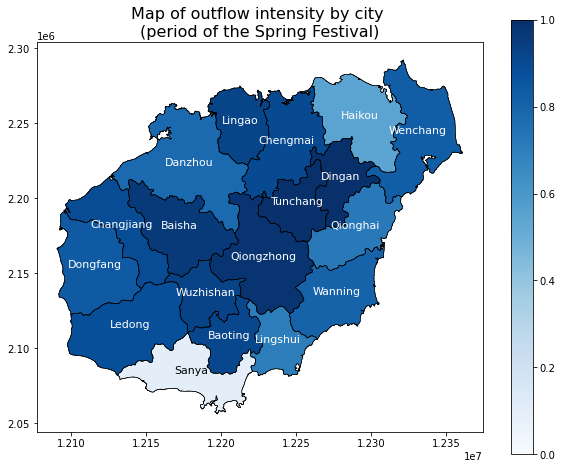

In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler

# Get sorted list of city names and list of inflows
df_0102_totalflow_orig_name = df_0102_totalflow_orig['Orig_name'].tolist()
df_0102_totalflow_orig_flows = df_0102_totalflow_orig['TotalNoIntra'].astype(int).tolist()

# Perform logarithmic conversions, taking care to handle 0 values, and adding a small constant to avoid negative logarithmic values.
df_0102_totalflow_orig_flows_log = np.log(np.array(df_0102_totalflow_orig_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_0102_totalflow_orig_flows_norlog = scaler.fit_transform(np.array(df_0102_totalflow_orig_flows_log).reshape(-1, 1)).flatten()

# Create graphs, one for each color mapping
cmap = plt.cm.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=1)

Hainan_shp['df_0102_totalflow_orig_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(df_0102_totalflow_orig_name, df_0102_totalflow_orig_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k')  # 绘制边界
Hainan_shp.plot(column='df_0102_totalflow_orig_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name == 'Sanya':
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')



# Setting the map title and color bar labels
ax.set_title('Map of outflow intensity by city \n(period of the Spring Festival)', fontsize=16)
plt.show()


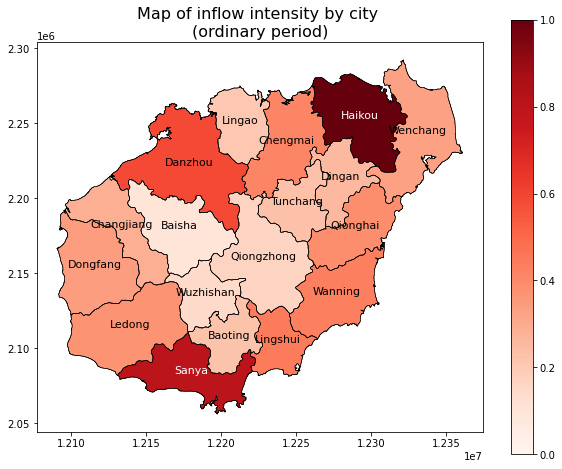

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn.preprocessing import StandardScaler

# Get sorted list of city names and list of inflows
df_0304_totalflow_dest_name = df_0304_totalflow_dest['Dest_name'].tolist()
df_0304_totalflow_dest_flows = df_0304_totalflow_dest['TotalNoIntra'].astype(int).tolist()

# Perform logarithmic conversions, taking care to handle 0 values, and adding a small constant to avoid negative logarithmic values.
df_0304_totalflow_dest_flows_log = np.log(np.array(df_0304_totalflow_dest_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_0304_totalflow_dest_flows_norlog = scaler.fit_transform(np.array(df_0304_totalflow_dest_flows_log).reshape(-1, 1)).flatten()

# Creating a Color Level Mapping
cmap = plt.cm.get_cmap('Reds')
norm = colors.Normalize(vmin=0, vmax=1)
#norm = colors.Normalize(vmin=min(total_flows_log), vmax=max(total_flows_log))

# Mapping the logarithmic inflow sort of a city to a color scale and storing it in a new column
Hainan_shp['df_0304_totalflow_dest_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(df_0304_totalflow_dest_name, df_0304_totalflow_dest_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k') 
Hainan_shp.plot(column='df_0102_totalflow_dest_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name in ['Sanya', 'Haikou']:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')

# Setting the map title and color bar labels
ax.set_title('Map of inflow intensity by city \n(ordinary period)', fontsize=16)

plt.show()

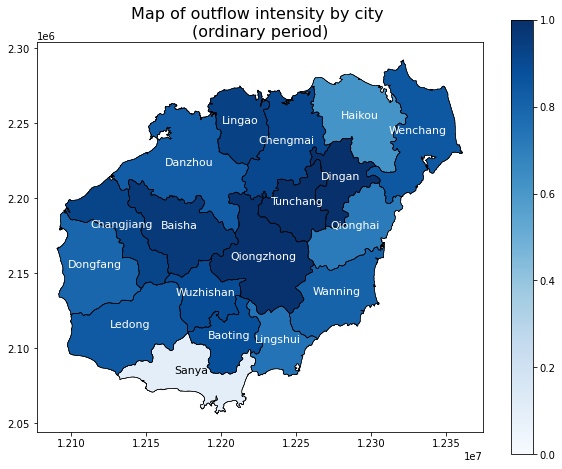

In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler

# Get sorted list of city names and list of inflows
df_0304_totalflow_orig_name = df_0304_totalflow_orig['Orig_name'].tolist()
df_0304_totalflow_orig_flows = df_0304_totalflow_orig['TotalNoIntra'].astype(int).tolist()

# Perform logarithmic conversions, taking care to handle 0 values, and adding a small constant to avoid negative logarithmic values.
df_0304_totalflow_orig_flows_log = np.log(np.array(df_0304_totalflow_orig_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_0304_totalflow_orig_flows_norlog = scaler.fit_transform(np.array(df_0304_totalflow_orig_flows_log).reshape(-1, 1)).flatten()

# Creating color maps
cmap = plt.cm.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=1)

# Mapping the normalized inflows of a city to a color scale and storing it in a new column
Hainan_shp['df_0304_totalflow_orig_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(df_0304_totalflow_orig_name, df_0304_totalflow_orig_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k')  
Hainan_shp.plot(column='df_0304_totalflow_orig_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name == 'Sanya':
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')



# Setting the map title and color bar labels
ax.set_title('Map of outflow intensity by city \n(ordinary period)', fontsize=16)

plt.show()


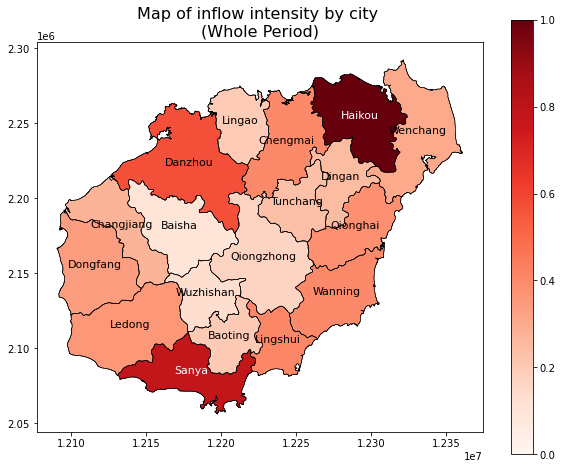

In [56]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn.preprocessing import StandardScaler

# Get sorted list of city names and list of inflows
merged_df_totalflow_dest_name = merged_df_totalflow_dest['Dest_name'].tolist()
merged_df_totalflow_dest_flows = merged_df_totalflow_dest['TotalNoIntra'].astype(int).tolist()

# Perform logarithmic conversions, taking care to handle 0 values, and adding a small constant to avoid negative logarithmic values.
merged_df_totalflow_dest_flows_log = np.log(np.array(merged_df_totalflow_dest_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
merged_df_totalflow_dest_flows_norlog = scaler.fit_transform(np.array(merged_df_totalflow_dest_flows_log).reshape(-1, 1)).flatten()

# Creating a Color Level Mapping
cmap = plt.cm.get_cmap('Reds')
norm = colors.Normalize(vmin=0, vmax=1)
#norm = colors.Normalize(vmin=min(total_flows_log), vmax=max(total_flows_log))

# Mapping the logarithmic inflow sort of a city to a color scale and storing it in a new column
Hainan_shp['merged_df_totalflow_dest_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(merged_df_totalflow_dest_name, merged_df_totalflow_dest_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k')  
Hainan_shp.plot(column='merged_df_totalflow_dest_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name in ['Sanya', 'Haikou']:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')

# Setting the map title and color bar labels
ax.set_title('Map of inflow intensity by city \n(Whole Period)', fontsize=16)

plt.show()

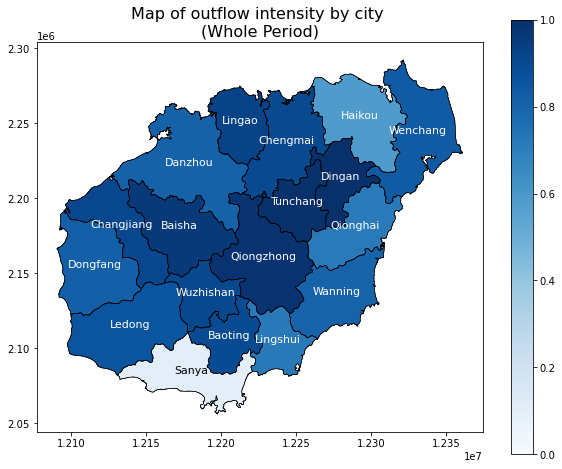

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler

# Get sorted list of city names and list of inflows
merged_df_totalflow_orig_name = merged_df_totalflow_orig['Orig_name'].tolist()
merged_df_totalflow_orig_flows = merged_df_totalflow_orig['TotalNoIntra'].astype(int).tolist()

# Perform logarithmic conversions, taking care to handle 0 values, and adding a small constant to avoid negative logarithmic values.
merged_df_totalflow_orig_flows_log = np.log(np.array(merged_df_totalflow_orig_flows) + 0.01)

# Normalization with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.1, 1))
merged_df_totalflow_orig_flows_norlog = scaler.fit_transform(np.array(merged_df_totalflow_orig_flows_log).reshape(-1, 1)).flatten()

# Creating color maps
cmap = plt.cm.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=1)

# Mapping the normalized inflows of a city to a color scale and storing it in a new column
Hainan_shp['merged_df_totalflow_orig_flows_norlog'] = Hainan_shp['Name'].map(dict(zip(merged_df_totalflow_orig_name, merged_df_totalflow_orig_flows_norlog)))

# map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
Hainan_shp.boundary.plot(ax=ax, linewidth=0.5, color='k')  
Hainan_shp.plot(column='merged_df_totalflow_orig_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax, edgecolor='k', legend=True, norm=norm)

# Label the name of the city
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name == 'Sanya':
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')
    else:
        ax.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')



# Setting the map title and color bar labels
ax.set_title('Map of outflow intensity by city \n(Whole Period)', fontsize=16)

plt.show()


### WP - Maps of urban inflows and outflows

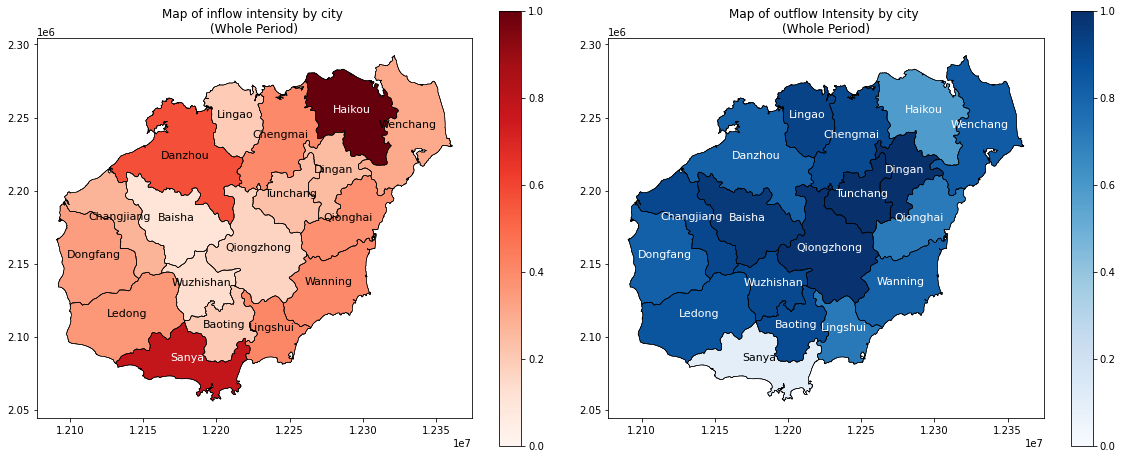

In [58]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8),gridspec_kw={'wspace': 0.05})


cmap = plt.cm.get_cmap('Reds')
norm = colors.Normalize(vmin=0, vmax=1)
ax1.set_title('Map of inflow intensity by city \n(Whole Period)')
Hainan_shp.boundary.plot(ax=ax1, linewidth=0.5, color='k')
Hainan_shp.plot(column='merged_df_totalflow_dest_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax1, edgecolor='k', legend=True, norm=norm)
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name in ['Sanya', 'Haikou']:
        ax1.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')
    else:
        ax1.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')

cmap = plt.cm.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=1)
ax2.set_title('Map of outflow Intensity by city \n(Whole Period)')
Hainan_shp.boundary.plot(ax=ax2, linewidth=0.5, color='k')
Hainan_shp.plot(column='merged_df_totalflow_orig_flows_norlog', cmap=cmap, linewidth=0.5, ax=ax2, edgecolor='k', legend=True, norm=norm)
for _, row in Hainan_shp.iterrows():
    city_name = row["Name"]
    centroid = row.geometry.centroid
    if city_name == 'Sanya':
        ax2.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='black')
    else:
        ax2.text(centroid.x, centroid.y, city_name, fontsize=11, ha='center', color='white')


plt.show()

### WP - Histogram of inflows and outflows

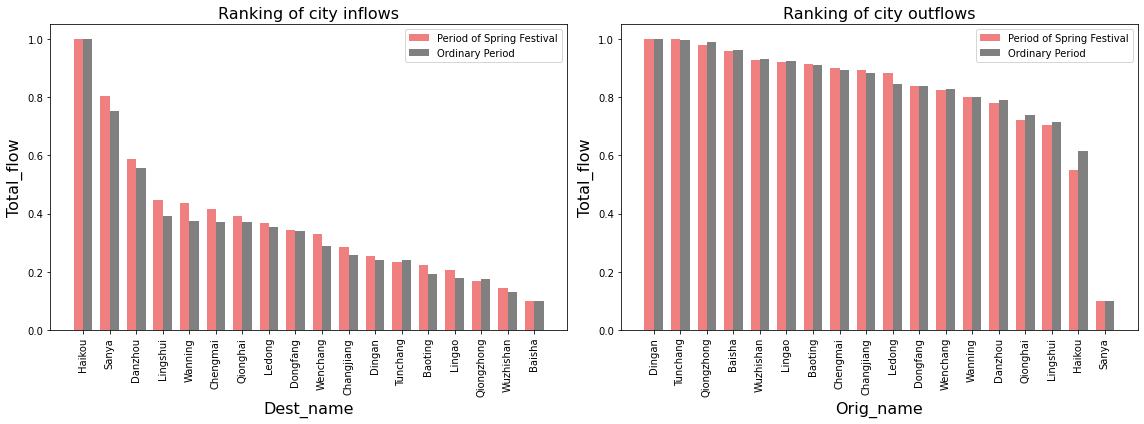

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of inflows
bar_width = 0.35
index = np.arange(len(df_0102_totalflow_dest_flows_norlog))
ax1.bar(index, df_0102_totalflow_dest_flows_norlog, bar_width, label='Period of Spring Festival', color='lightcoral')
ax1.bar(index + bar_width, df_0304_totalflow_dest_flows_norlog, bar_width, label='Ordinary Period',color='gray')
ax1.set_xlabel('Dest_name', fontsize=16)
ax1.set_ylabel('Total_flow', fontsize=16)
ax1.set_title('Ranking of city inflows', fontsize=16)
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(df_0102_totalflow_dest_name, rotation=90)
ax1.legend()

#  Histogram of outflows
index = np.arange(len(df_0102_totalflow_orig_flows_norlog))
ax2.bar(index, df_0102_totalflow_orig_flows_norlog, bar_width, label='Period of Spring Festival', color='lightcoral')
ax2.bar(index + bar_width, df_0304_totalflow_orig_flows_norlog, bar_width, label='Ordinary Period', color='gray')
ax2.set_xlabel('Orig_name', fontsize=16)
ax2.set_ylabel('Total_flow', fontsize=16)
ax2.set_title('Ranking of city outflows', fontsize=16)
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(df_0102_totalflow_orig_name, rotation=90)
ax2.legend()

plt.tight_layout()
plt.show()


### SFP, inflow line graphs

In [65]:
dates = [col for col in df_0102.columns if re.match("^\d+$", col) is not None] 

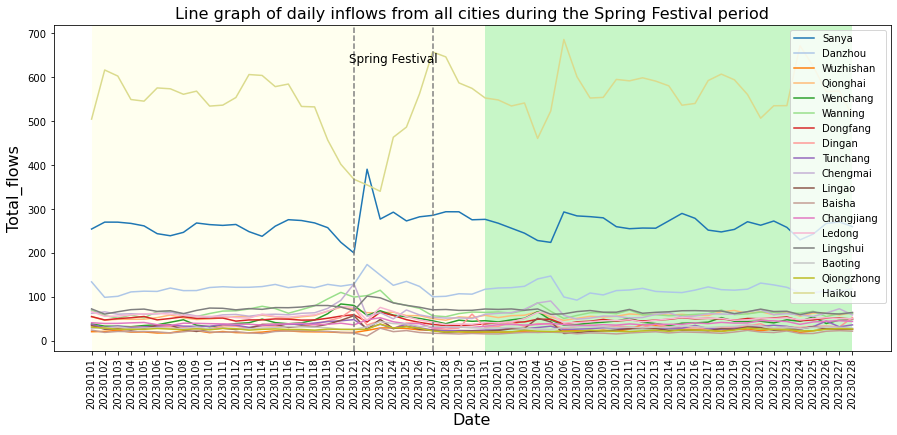

In [66]:
fig = plt.figure(figsize=(15, 6))
color_map = plt.get_cmap('tab20')  # Uses tab20 color mapping with 20 different colors

#Get city list and index
cities = df_0102['Dest_name'].unique()
city_indices = np.arange(len(cities))

for i, city in zip(city_indices, cities):
    data = df_0102[df_0102['Dest_name'] == city][dates].sum()
    color = color_map(i)  # Use different colors
    plt.plot(dates, data, label=city, color=color)

plt.xlabel('Date', fontsize=16)
plt.ylabel('Total_flows', fontsize=16)
plt.title('Line graph of daily inflows from all cities during the Spring Festival period', fontsize=16)
plt.text(0.44, 0.8, 'Spring Festival', transform=fig.transFigure, ha='center', va='center', fontsize=12)
plt.legend()
plt.xticks(np.arange(len(dates)), dates, rotation=90)
plt.axvline(x=20, linestyle='--', color='gray')
plt.axvline(x=26, linestyle='--', color='gray')
plt.axvspan(0, 30, facecolor='lightyellow', alpha=0.5)
plt.axvspan(30, 58, facecolor='lightgreen', alpha=0.5)
plt.show()

### SFP, line graph of outflows

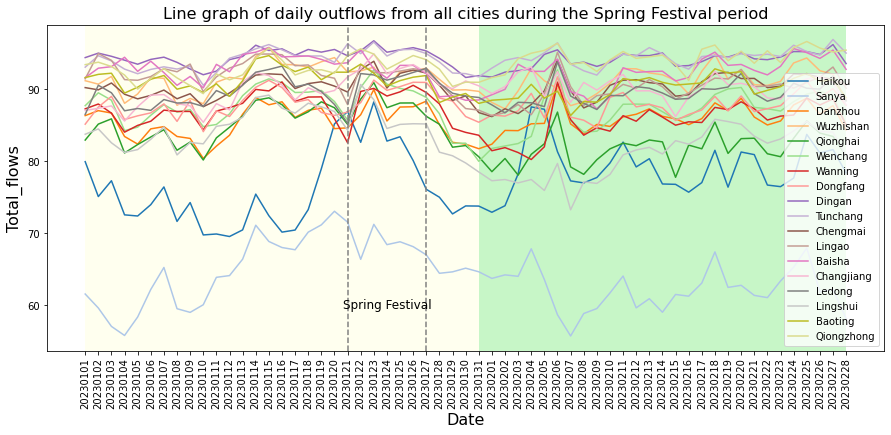

In [67]:
fig = plt.figure(figsize=(15, 6))
color_map = plt.get_cmap('tab20')  


cities = df_0102['Orig_name'].unique()
city_indices = np.arange(len(cities))

for i, city in zip(city_indices, cities):
    data = df_0102[df_0102['Orig_name'] == city][dates].sum()
    color = color_map(i)  
    plt.plot(dates, data, label=city, color=color)

plt.xlabel('Date', fontsize=16)
plt.ylabel('Total_flows', fontsize=16)
plt.title('Line graph of daily outflows from all cities during the Spring Festival period', fontsize=16)
plt.text(0.44, 0.23, 'Spring Festival', transform=fig.transFigure, ha='center', va='center', fontsize=12)
plt.legend()
plt.xticks(np.arange(len(dates)), dates, rotation=90)
plt.axvline(x=20, linestyle='--', color='gray')
plt.axvline(x=26, linestyle='--', color='gray')
plt.axvspan(0, 30, facecolor='lightyellow', alpha=0.5)
plt.axvspan(30, 58, facecolor='lightgreen', alpha=0.5)
plt.show()

### OP - line graph of inflows

In [68]:
dates = [col for col in df_0304.columns if re.match("^\d+$", col) is not None]  # 假设日期列从第6列开始

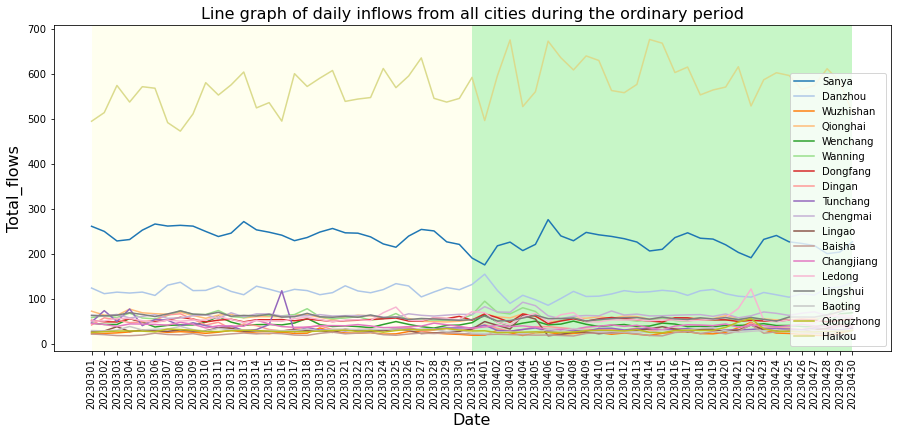

In [69]:
fig = plt.figure(figsize=(15, 6))
color_map = plt.get_cmap('tab20')  


cities = df_0304['Dest_name'].unique()
city_indices = np.arange(len(cities))

for i, city in zip(city_indices, cities):
    data = df_0304[df_0304['Dest_name'] == city][dates].sum()
    color = color_map(i)  
    plt.plot(dates, data, label=city, color=color)

plt.xlabel('Date', fontsize=16)
plt.ylabel('Total_flows', fontsize=16)
plt.title('Line graph of daily inflows from all cities during the ordinary period', fontsize=16)
plt.legend(loc='lower right')
plt.xticks(np.arange(len(dates)), dates, rotation=90)

plt.axvspan(0, 30, facecolor='lightyellow', alpha=0.5)
plt.axvspan(30, 60, facecolor='lightgreen', alpha=0.5)
plt.show()

### OP - line graph of outflows

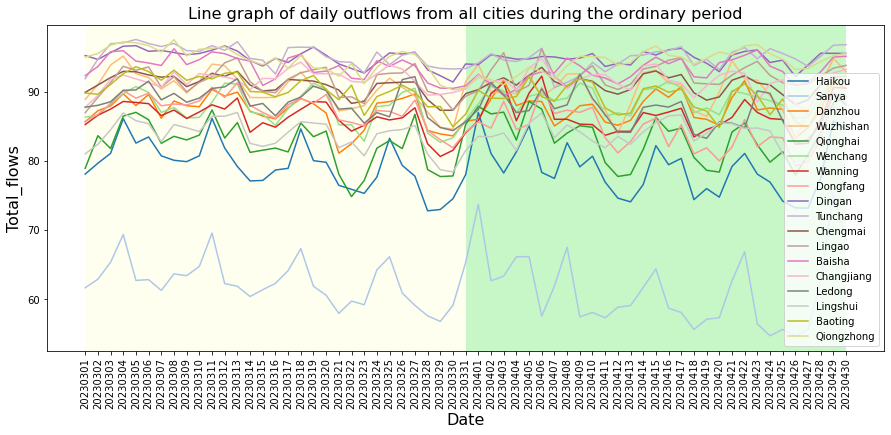

In [70]:
fig = plt.figure(figsize=(15, 6))
color_map = plt.get_cmap('tab20')  


cities = df_0304['Orig_name'].unique()
city_indices = np.arange(len(cities))

for i, city in zip(city_indices, cities):
    data = df_0304[df_0304['Orig_name'] == city][dates].sum()
    color = color_map(i)  
    plt.plot(dates, data, label=city, color=color)

plt.xlabel('Date', fontsize=16)
plt.ylabel('Total_flows', fontsize=16)
plt.title('Line graph of daily outflows from all cities during the ordinary period', fontsize=16)
plt.legend(loc='lower right')
plt.xticks(np.arange(len(dates)), dates, rotation=90)

plt.axvspan(0, 30, facecolor='lightyellow', alpha=0.5)
plt.axvspan(30, 60, facecolor='lightgreen', alpha=0.5)
plt.show()

### Filtering data with Haikou City as the starting point

In [71]:
haikou_flow_0102_orig  = df_0102[df_0102['Orig_name'] == 'Haikou']
haikou_flow_0304_orig  = df_0304[df_0304['Orig_name'] == 'Haikou']
haikou_flow_merged_df_orig = merged_df[merged_df['Orig_name'] == 'Haikou']

### Filtering data with Haikou City as the endpoint

In [72]:
haikou_flow_0102_dest  = df_0102[df_0102['Dest_name'] == 'Haikou']
haikou_flow_0304_dest  = df_0304[df_0304['Dest_name'] == 'Haikou']
haikou_flow_merged_df_dest = merged_df[merged_df['Dest_name'] == 'Haikou']

### Filtering data with Sanya City as the endpoint

In [73]:
Sanya_flow_0102_dest  = df_0102[df_0102['Dest_name'] == 'Sanya']
Sanya_flow_0304_dest  = df_0304[df_0304['Dest_name'] == 'Sanya']
Sanya_flow_merged_df_dest = merged_df[merged_df['Dest_name'] == 'Sanya']

### Filtering data with Sanya City as the starting point

In [74]:
Sanya_flow_0102_orig  = df_0102[df_0102['Orig_name'] == 'Sanya']
Sanya_flow_0304_orig  = df_0304[df_0304['Orig_name'] == 'Sanya']
Sanya_flow_merged_df_orig = merged_df[merged_df['Orig_name'] == 'Sanya']

### WP-Inflow and outflow maps for Haikou City as endpoints and endpoints, respectively

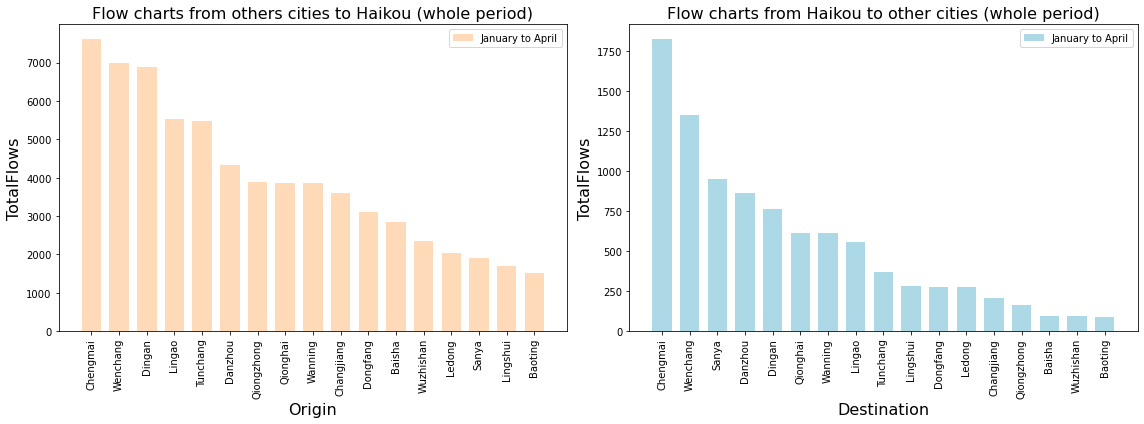

In [75]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort by TotalNoIntra in descending order
sorted_haikou_flow_merged_df_dest = haikou_flow_merged_df_dest.sort_values('TotalNoIntra', ascending=False)
# Set the width of each color bar
bar_width = 0.7
# Creating Histograms
ax1.bar(np.arange(len(sorted_haikou_flow_merged_df_dest)), sorted_haikou_flow_merged_df_dest['TotalNoIntra'], width=bar_width, color='peachpuff', label='January to April')
# Setting the X-axis scale labels
ax1.set_xticks(np.arange(len(sorted_haikou_flow_merged_df_dest)) , sorted_haikou_flow_merged_df_dest['Orig_name'])
# Setting up graph titles and axis labels
ax1.set_title('Flow charts from others cities to Haikou (whole period)', fontsize=16)
ax1.set_xlabel('Origin', fontsize=16)
ax1.set_ylabel('TotalFlows', fontsize=16)
ax1.set_xticklabels(sorted_haikou_flow_merged_df_dest['Orig_name'],rotation=90)

ax1.legend()


sorted_data_0102 = haikou_flow_0102_orig.sort_values('TotalNoIntra', ascending=False)
sorted_data_0304 = haikou_flow_0304_orig.sort_values('TotalNoIntra', ascending=False)
sorted_haikou_flow_merged_df_orig = haikou_flow_merged_df_orig.sort_values('TotalNoIntra', ascending=False)

bar_width = 0.7

ax2.bar(np.arange(len(sorted_haikou_flow_merged_df_orig)), sorted_haikou_flow_merged_df_orig['TotalNoIntra'], width=bar_width,  color='lightblue', label='January to April')

ax2.set_xticks(np.arange(len(sorted_haikou_flow_merged_df_orig)) , sorted_haikou_flow_merged_df_orig['Dest_name'])

ax2.set_title("Flow charts from Haikou to other cities (whole period)", fontsize=16)
ax2.set_xlabel('Destination', fontsize=16)
ax2.set_ylabel('TotalFlows', fontsize=16)
ax2.set_xticklabels(sorted_haikou_flow_merged_df_orig['Dest_name'], rotation=90)

ax2.legend()

plt.tight_layout()
plt.show()

### WP-Maps of inflows and outflows for Sanya City as endpoints and endpoints, respectively

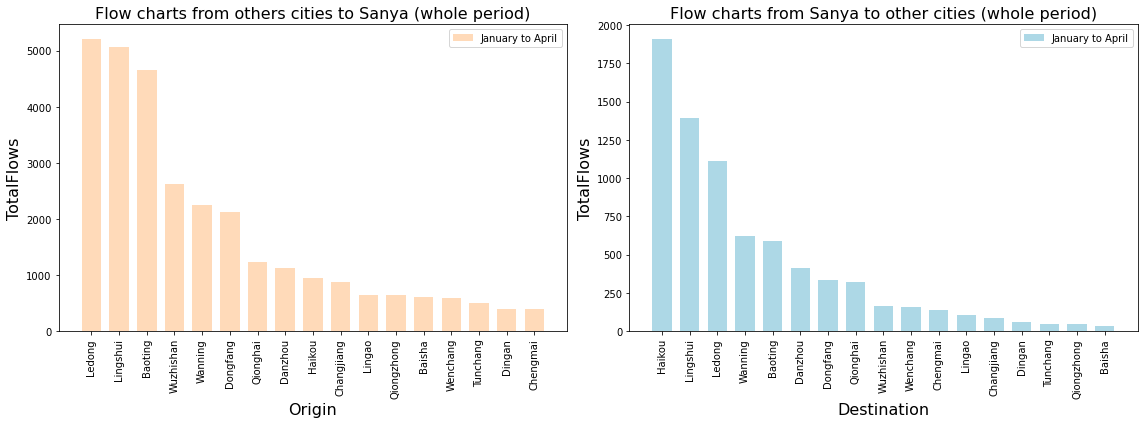

In [76]:
# 创建一个包含两个子图的图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort by TotalNoIntra in descending order
sorted_sanya_flow_merged_df_dest = Sanya_flow_merged_df_dest.sort_values('TotalNoIntra', ascending=False)
# Set the width of each color bar
bar_width = 0.7
# Creating Histograms
ax1.bar(np.arange(len(sorted_sanya_flow_merged_df_dest)), sorted_sanya_flow_merged_df_dest['TotalNoIntra'], width=bar_width, color='peachpuff', label='January to April')
# Setting the X-axis scale labels
ax1.set_xticks(np.arange(len(sorted_sanya_flow_merged_df_dest)) , sorted_sanya_flow_merged_df_dest['Orig_name'])
#  Setting up graph titles and axis labels
ax1.set_title('Flow charts from others cities to Sanya (whole period)', fontsize=16)
ax1.set_xlabel('Origin', fontsize=16)
ax1.set_ylabel('TotalFlows', fontsize=16)
ax1.set_xticklabels(sorted_sanya_flow_merged_df_dest['Orig_name'],rotation=90)

ax1.legend()


sorted_sanya_flow_merged_df_orig = Sanya_flow_merged_df_orig.sort_values('TotalNoIntra', ascending=False)

bar_width = 0.7

ax2.bar(np.arange(len(sorted_sanya_flow_merged_df_orig)), sorted_sanya_flow_merged_df_orig['TotalNoIntra'], width=bar_width,  color='lightblue', label='January to April')

ax2.set_xticks(np.arange(len(sorted_sanya_flow_merged_df_orig)) , sorted_sanya_flow_merged_df_orig['Dest_name'])

ax2.set_title("Flow charts from Sanya to other cities (whole period)", fontsize=16)
ax2.set_xlabel('Destination', fontsize=16)
ax2.set_ylabel('TotalFlows', fontsize=16)
ax2.set_xticklabels(sorted_sanya_flow_merged_df_orig['Dest_name'], rotation=90)

ax2.legend()

plt.tight_layout()
plt.show()


### WP-Map of inflows and outflows by city

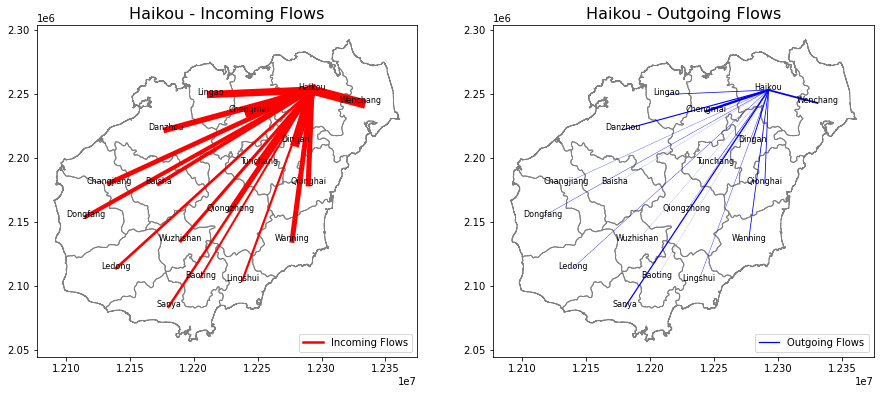

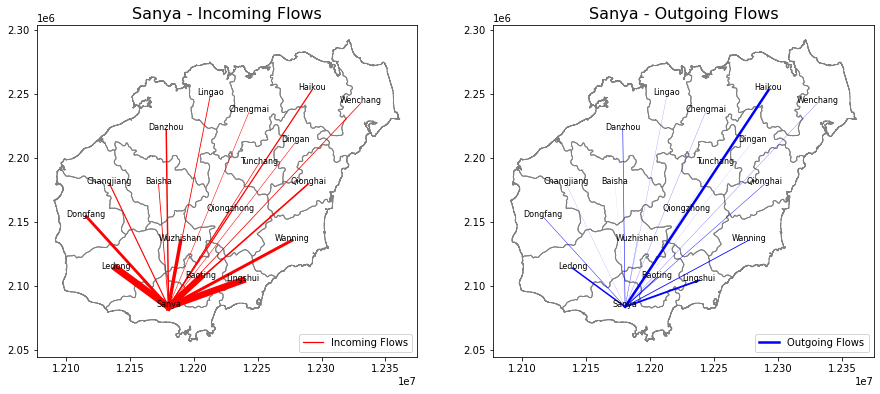

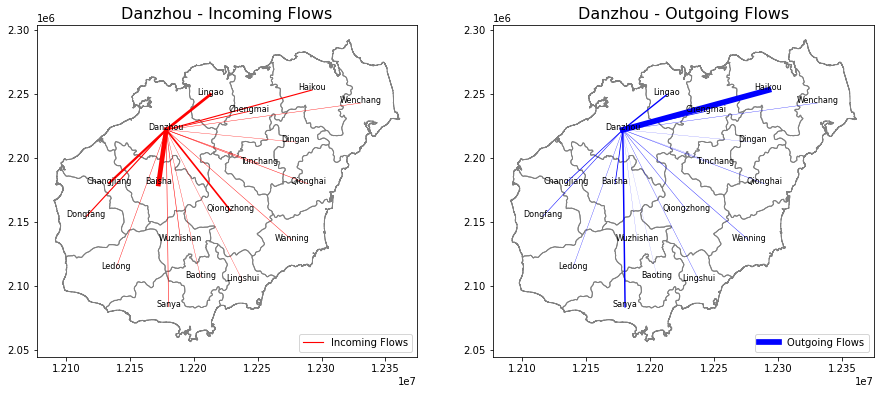

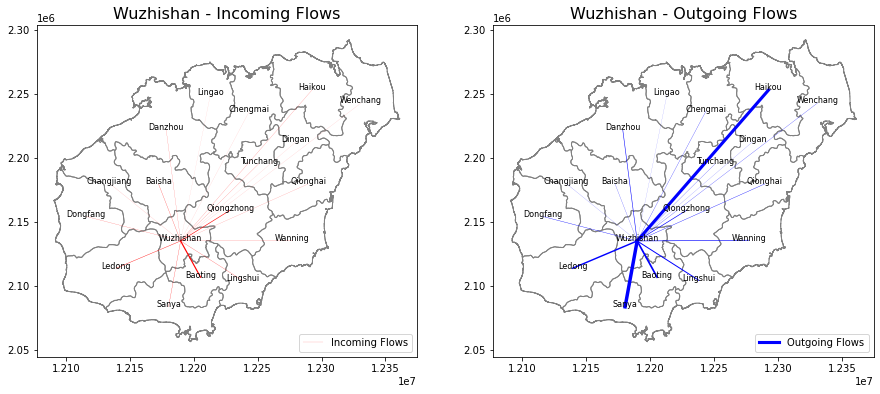

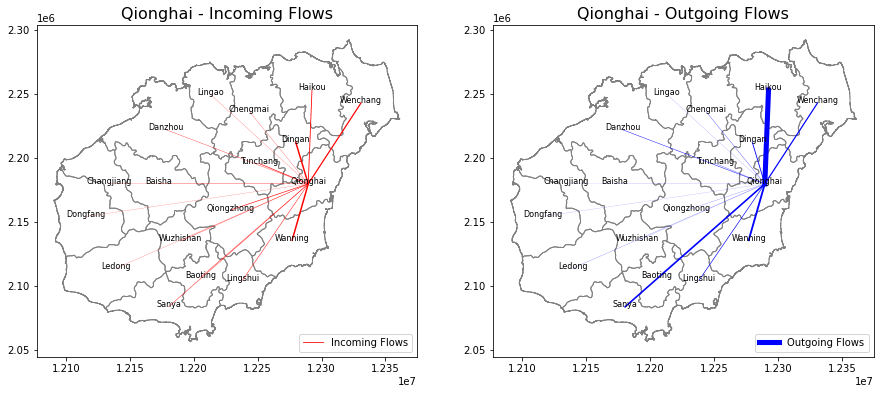

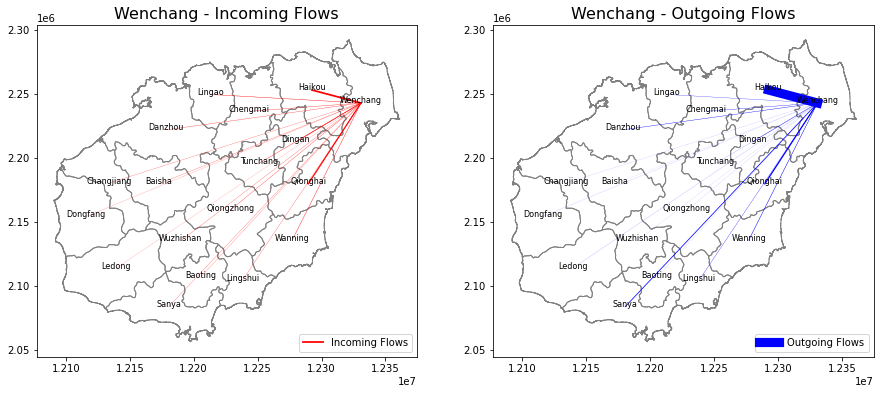

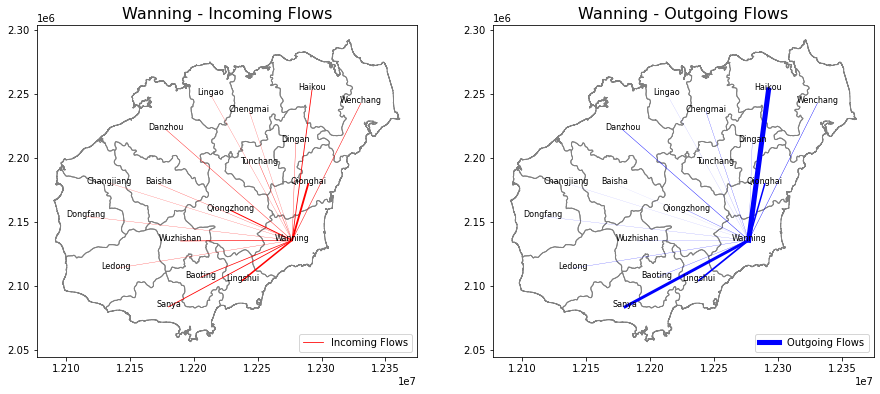

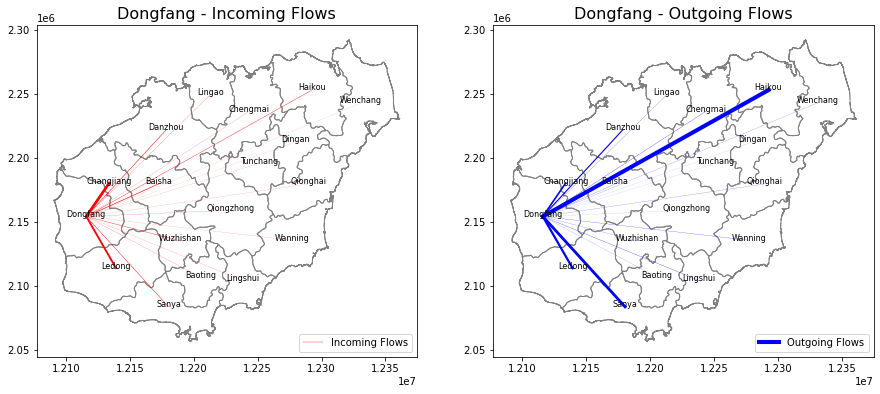

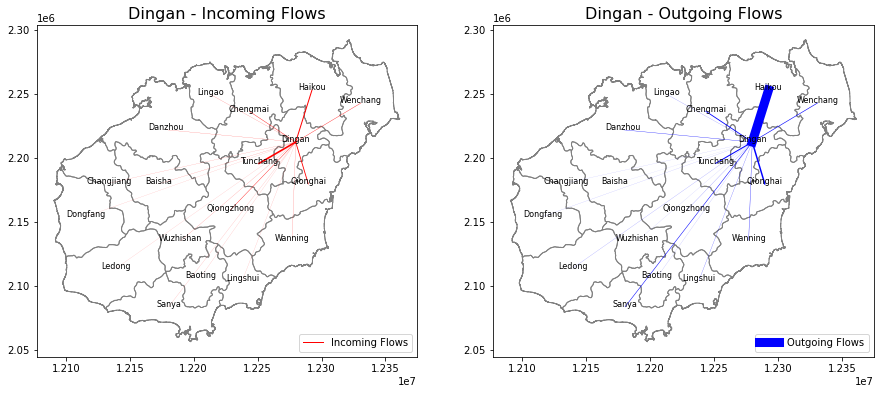

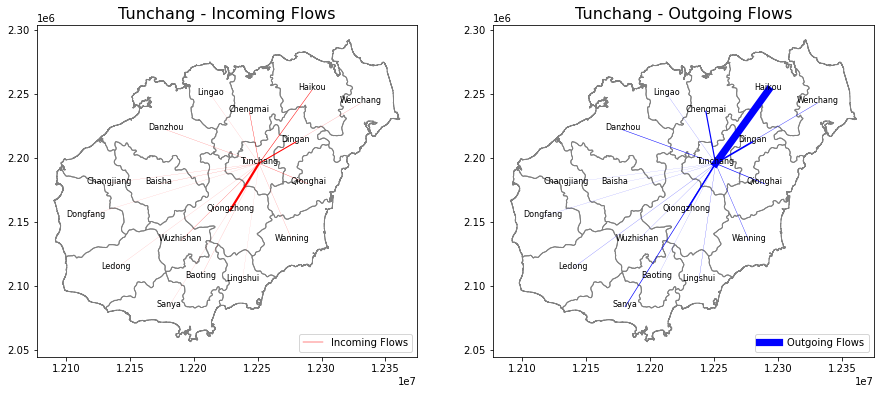

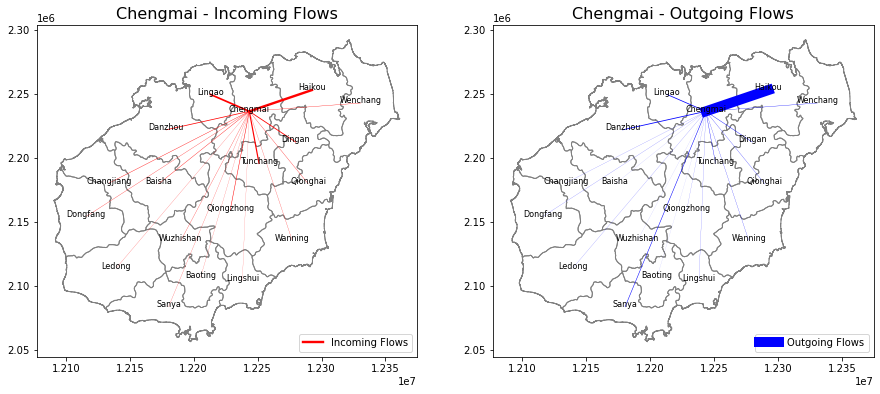

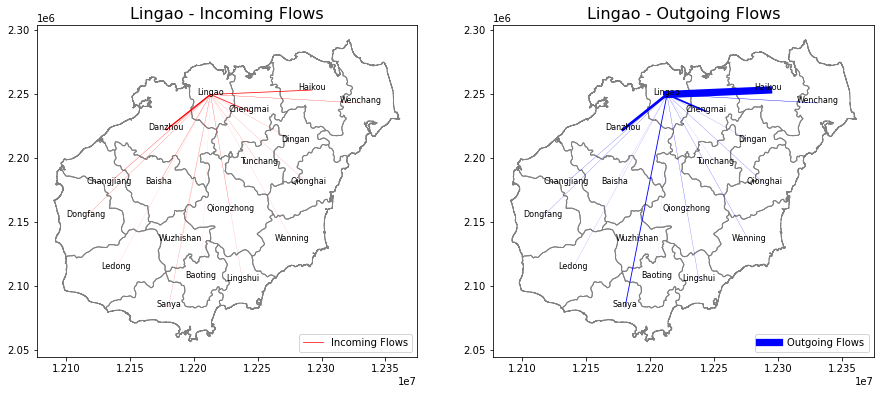

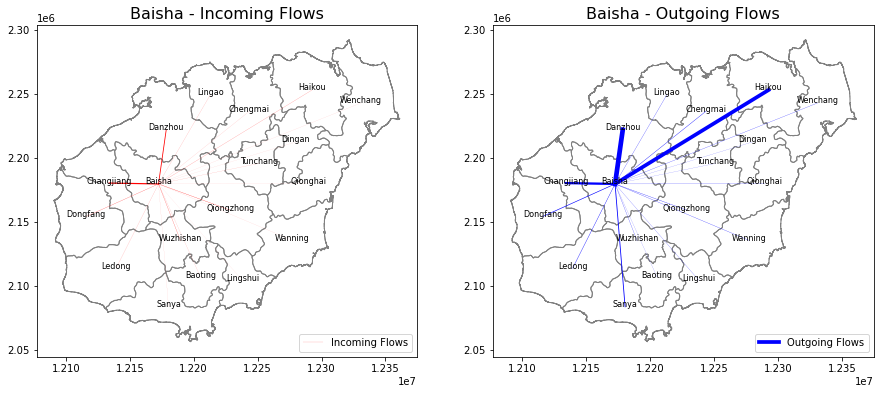

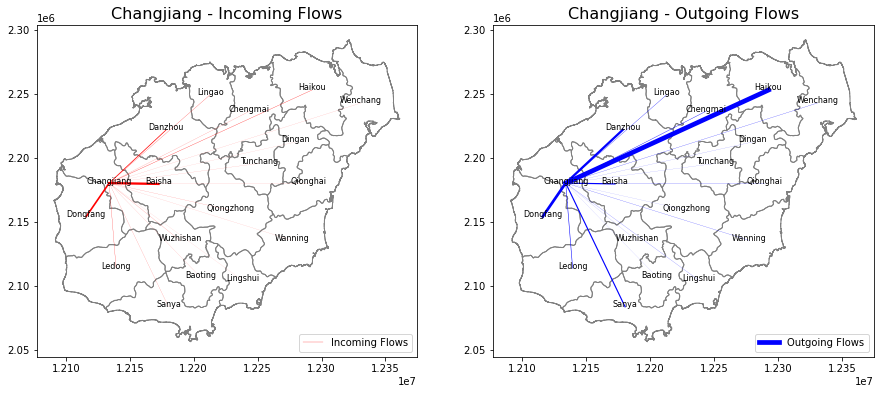

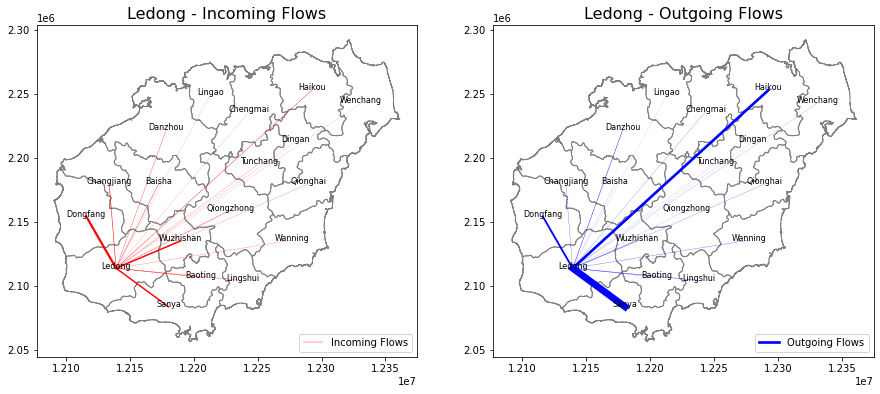

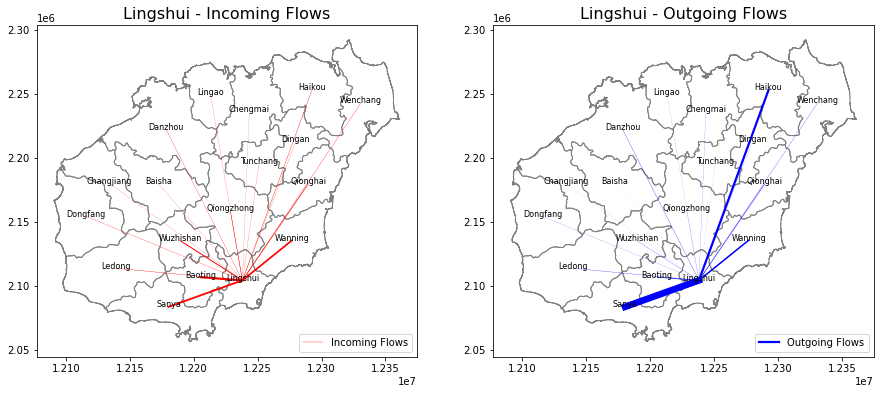

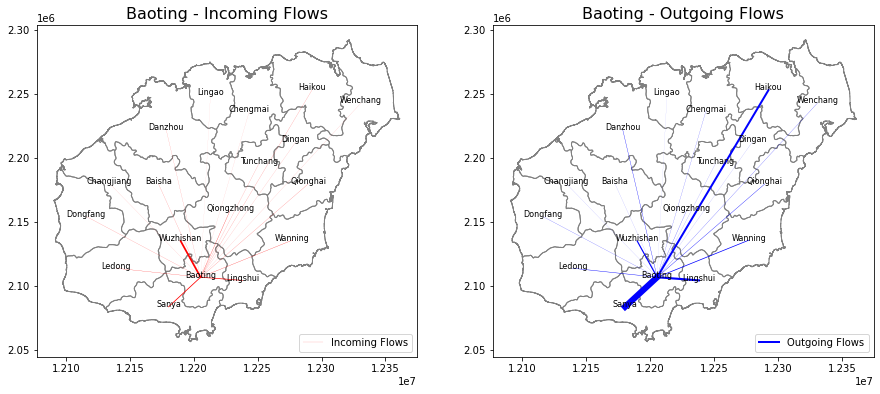

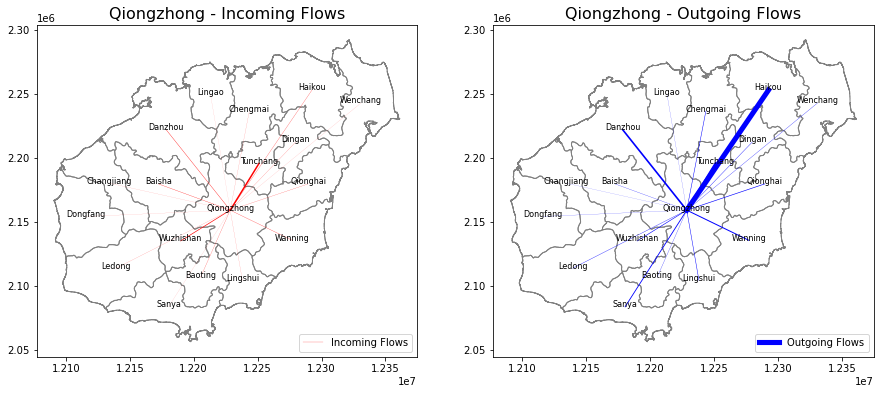

In [77]:
# Iterate through the list of cities to generate a chart
for city in cities:
    fig, axes = plt.subplots(ncols=2, figsize=(15, 30))
    
    # Adjusting the spacing between subgraphs
    plt.subplots_adjust(wspace=0.2)
    
    # Filtering data whose starting point is the current city
    orig_data = merged_df[merged_df['Orig_name'] == city]
    # Filter data with endpoints in the current city
    dest_data = merged_df[merged_df['Dest_name'] == city]
    
    
        # Left subgraph: flow map from other cities to current city
    ax1 = axes[0]
    Hainan_shp.plot(ax=ax1, facecolor="None", edgecolor="gray")
    for index, row in dest_data.iterrows():
        x1 = [Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].x,
              Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].x]
        y1 = [Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].y,
              Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].y]
        ax1.plot(x1, y1, linewidth=row["TotalNoIntra"] / max(merged_df["TotalNoIntra"]) * 10, color="red")
        #ax2.annotate(str(int(row["TotalNoIntra"])), 
                     #xy=(Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].x, 
                         #Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].y),
                     #xytext=(0, 7),
                     #textcoords="offset points",
                     #ha='center',
                     #color='green')
    ax1.set_title(city + ' - Incoming Flows', fontsize=16)
    

    # Right subgraph: flow map from current city to other cities
    ax2 = axes[1]
    Hainan_shp.plot(ax=ax2, facecolor="None", edgecolor="gray")
    for index, row in orig_data.iterrows():
        x1 = [Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].x,
              Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].x]
        y1 = [Hainan_shp[Hainan_shp["code"] == row["Orig_code"]]["Centroids"].y,
              Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].y]

        ax2.plot(x1, y1, linewidth=row["TotalNoIntra"] / max(merged_df["TotalNoIntra"]) * 10, color="blue")
              
        #ax1.annotate(str(int(row["TotalNoIntra"])), 
                     #xy=(Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].x, 
                         #Hainan_shp[Hainan_shp["code"] == row["Dest_code"]]["Centroids"].y),
                     #xytext=(0, 7),
                     #textcoords="offset points",
                     #ha='center',
                     #color='green')
        
        ax2.set_title(city + ' - Outgoing Flows', fontsize=16)
    
    # Add Legend
    ax1.legend(['Incoming Flows'], loc='lower right')
    ax2.legend(['Outgoing Flows'], loc='lower right')
    
    # Label all city names
    for _, row in Hainan_shp.iterrows():
        city_name = row["Name"]
        centroid = row["Centroids"]
        ax1.text(centroid.x, centroid.y, city_name, transform=ax1.transData, fontsize=8, ha='center')
        ax2.text(centroid.x, centroid.y, city_name, transform=ax2.transData, fontsize=8, ha='center')

    plt.show()


# Model Training and Fitting

### Define the R² and RMSE functions

In [78]:
def CalcRMSE(observed, estimated):
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

def CalcRSqaured(observed, estimated):

    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2

    return R2

### Calculation of multicollinearity for all socio-economic indicators

In [79]:
indicator_columns = [col for col in social_indicators.columns if col not in ['name', 'code']]
x_variables = [f"{col}_Orig" for col in indicator_columns] + [f"{col}_Dest" for col in indicator_columns]
x_variables.append('Dist')
x_variables

['population_Orig',
 'GDP_growth_rate_Orig',
 'tertiary_industry_rate_Orig',
 'per_capita_income_Orig',
 'ave_house_prices_Orig',
 'per_capita_green_Orig',
 'population_Dest',
 'GDP_growth_rate_Dest',
 'tertiary_industry_rate_Dest',
 'per_capita_income_Dest',
 'ave_house_prices_Dest',
 'per_capita_green_Dest',
 'Dist']

In [80]:
# Define functions to calculate and remove variables with the highest VIFs
def drop_column_using_vif_(df, thresh=5):

    while True:
        # To add constant items to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # Deletion of constant items
        vif_df = vif_df.drop('const')
        
        # If the maximum VIF is greater than the threshold, the variable with the maximum VIF is removed
        # If there is more than one variable with VIF>threshold, only one of them is deleted. 
        if vif_df.VIF.max() > thresh:
            # If there is more than one variable with a maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF exceeds the threshold. Exit loop
            break

    return df

# Specify a list of thresholds and predictor variables
thresh = 5


# Select predictor variables from the data frame and perform multicollinearity checks

df_predictors = merged_df[x_variables].copy()  # Select the predictor variables to be examined
df_predictors_with_const = add_constant(df_predictors)  # Adding a constant term

# Loop through the columns with the highest VIF until no VIF exceeds the threshold
df_no_multicollinearity = drop_column_using_vif_(df_predictors_with_const, thresh)

print(df_no_multicollinearity.columns)


Index(['const', 'population_Orig', 'GDP_growth_rate_Orig',
       'tertiary_industry_rate_Orig', 'per_capita_income_Orig',
       'ave_house_prices_Orig', 'per_capita_green_Orig', 'population_Dest',
       'GDP_growth_rate_Dest', 'tertiary_industry_rate_Dest',
       'per_capita_income_Dest', 'ave_house_prices_Dest',
       'per_capita_green_Dest', 'Dist'],
      dtype='object')


### Calculate VIF values for all indicators

In [81]:
# Suppose df_predictors is a dataframe containing predictor variables

# Adding a constant term
df_predictors_with_const = add_constant(df_predictors)

# Calculate the VIF value for each variable
vif_values = [variance_inflation_factor(df_predictors_with_const.values, i)
              for i in range(df_predictors_with_const.shape[1])]

#Creating a results table
vif_results = pd.DataFrame({'Variable': df_predictors_with_const.columns,
                            'VIF': vif_values})

# Removing constant terms
vif_results = vif_results[vif_results['Variable'] != 'const']

print(vif_results)

                       Variable       VIF
1               population_Orig  3.178213
2          GDP_growth_rate_Orig  1.603047
3   tertiary_industry_rate_Orig  2.212115
4        per_capita_income_Orig  3.148125
5         ave_house_prices_Orig  1.837277
6         per_capita_green_Orig  1.375710
7               population_Dest  3.178213
8          GDP_growth_rate_Dest  1.603047
9   tertiary_industry_rate_Dest  2.212115
10       per_capita_income_Dest  3.148125
11        ave_house_prices_Dest  1.837277
12        per_capita_green_Dest  1.375710
13                         Dist  1.232727


In [82]:
df_no_multicollinearity = df_no_multicollinearity.drop('const', axis=1)

In [83]:
print(df_no_multicollinearity.columns)

Index(['population_Orig', 'GDP_growth_rate_Orig',
       'tertiary_industry_rate_Orig', 'per_capita_income_Orig',
       'ave_house_prices_Orig', 'per_capita_green_Orig', 'population_Dest',
       'GDP_growth_rate_Dest', 'tertiary_industry_rate_Dest',
       'per_capita_income_Dest', 'ave_house_prices_Dest',
       'per_capita_green_Dest', 'Dist'],
      dtype='object')


### All indicators that pass the covariance check are added to the total flows column

In [84]:
correlation_matrix = df_no_multicollinearity.join(merged_df["TotalNoIntra"])

### Plotting the correlation matrix

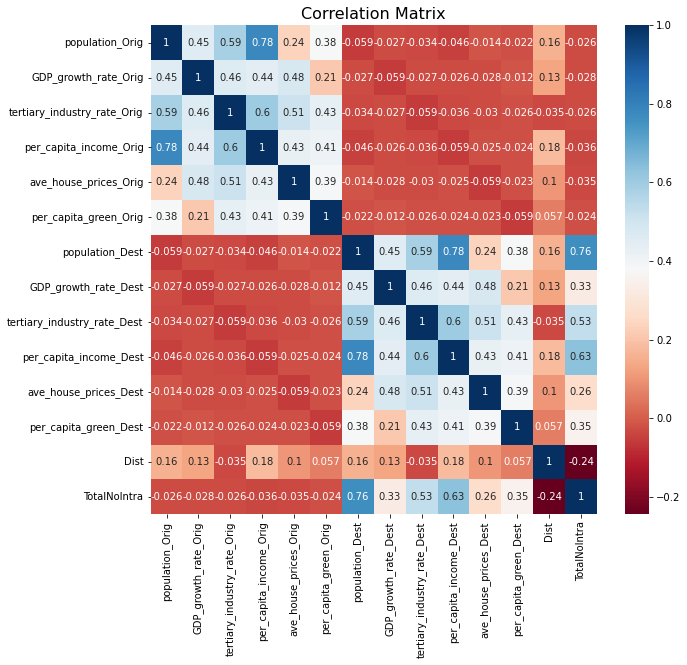

In [85]:
f = plt.figure(figsize=(10, 9)) 
sns.heatmap(correlation_matrix.corr(), annot=True, cmap='RdBu', xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix', fontsize=16)
_ = plt.xticks(rotation=90)

### Scatterplot of correlation between flows and other socio-economic indicator variables

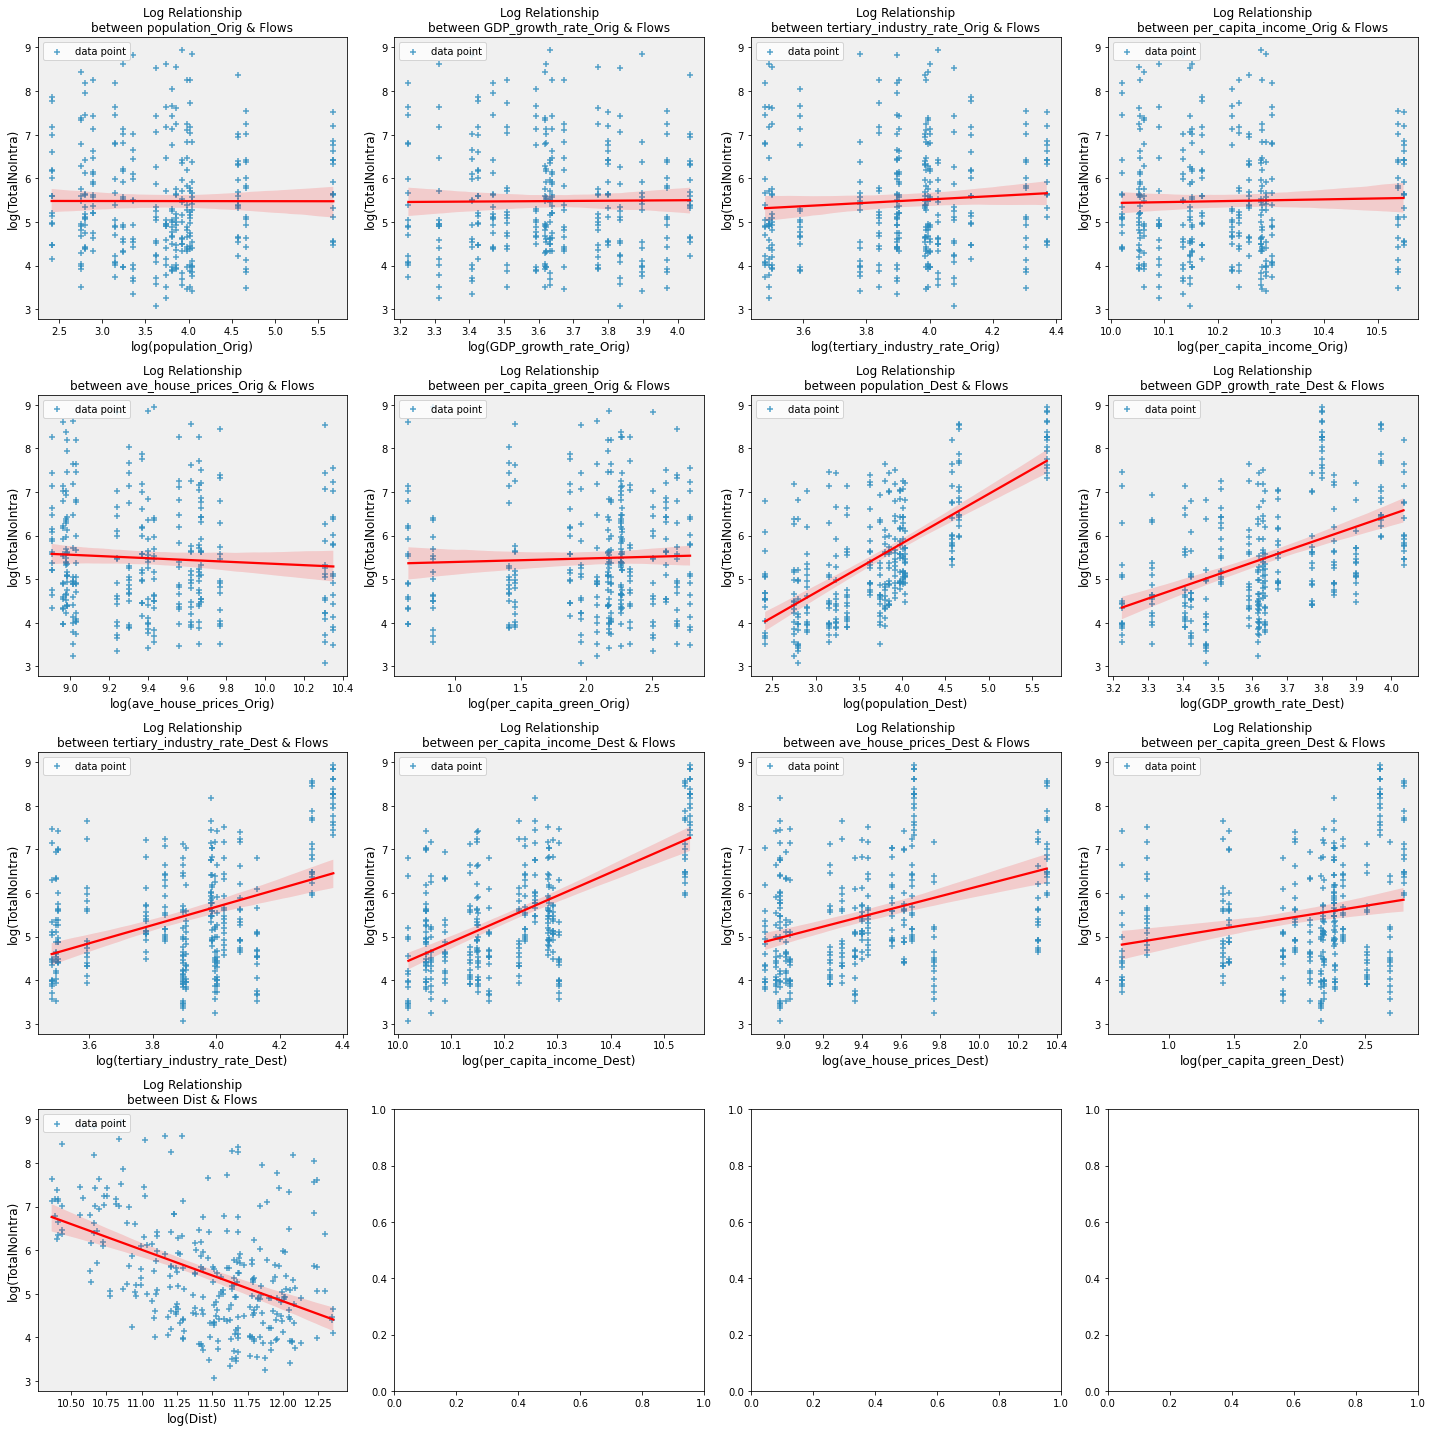

In [88]:
# List of x variables
x_variables = df_no_multicollinearity.columns

# Calculate the number of rows and columns for subplots
num_plots = len(x_variables)
num_cols = 4
num_rows = 4

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Adjust horizontal spacing between subplots
plt.subplots_adjust(wspace=1)

# Loop through each x variable and plot in subplots
for i, x_var in enumerate(x_variables):
    # Subset the dataframe to the flows we want
    merged_df_flows = merged_df[["TotalNoIntra", x_var]]
    # Remove all 0 values (logarithms can't deal with 0 values)
    merged_df_flows = merged_df_flows[(merged_df_flows!=0).all(1)]
    
    # Extract the x and y converting to log
    x = np.log(merged_df_flows[x_var])
    y = np.log(merged_df_flows["TotalNoIntra"])
    
    # Determine the subplot location
    row = i // num_cols
    col = i % num_cols
    
    # Plot the results along with the line of best fit in the corresponding subplot
    sns.regplot(x=x, y=y, marker="+", ax=axes[row, col], color="#2b8cbe", line_kws={"color":"red"})
    
    # Set labels and titles for the subplot
    axes[row, col].set_xlabel(f"log({x_var})", fontsize=12)
    axes[row, col].set_ylabel("log(TotalNoIntra)", fontsize=12)
    axes[row, col].set_title(f"Log Relationship\nbetween {x_var} & Flows", fontsize=12)

    # Set legend for the subplot
    axes[row, col].legend(labels=["data point"], loc="upper left")
    
    # Set background color for the subplot
    axes[row, col].set_facecolor("#f0f0f0")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


## Gravity model fitting

### SFP-gravity model

In [91]:
#take the variables and produce logarithms of them
x_variables = df_no_multicollinearity.columns.tolist() 

log_x_vars = []
for x in x_variables:
    df_0102[f"log_{x}"] = np.log(df_0102[x])
    log_x_vars.append(f"log_{x}")

# df_0102['log_TotalNoIntra'] = np.log(df_0102['TotalNoIntra'])
# Replace the independent variable portion of the formula
formula = f'TotalNoIntra ~ {" + ".join(log_x_vars)}'

print(formula)
#run the regression
uncosim = smf.glm(formula = formula, 
                  data=df_0102, 
                  family=sm.families.Poisson()).fit()

TotalNoIntra ~ log_population_Orig + log_GDP_growth_rate_Orig + log_tertiary_industry_rate_Orig + log_per_capita_income_Orig + log_ave_house_prices_Orig + log_per_capita_green_Orig + log_population_Dest + log_GDP_growth_rate_Dest + log_tertiary_industry_rate_Dest + log_per_capita_income_Dest + log_ave_house_prices_Dest + log_per_capita_green_Dest + log_Dist


In [92]:
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           TotalNoIntra   No. Observations:                  306
Model:                            GLM   Df Residuals:                      292
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11504.
Date:                Thu, 24 Aug 2023   Deviance:                       20985.
Time:                        22:31:50   Pearson chi2:                 2.40e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [93]:
K = uncosim.params[0]
alpha0 = uncosim.params[1]
alpha1 = uncosim.params[2]
alpha2 = uncosim.params[3]
alpha3 = uncosim.params[4]
alpha4 = uncosim.params[5]
alpha5 = uncosim.params[6]
gamma0 = uncosim.params[7]
gamma1 = uncosim.params[8]
gamma2 = uncosim.params[9]
gamma3 = uncosim.params[10]
gamma4 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

### The estimated parameters were brought into a Poisson gravity model to predict the flows

In [94]:

df_0102["unconstrainedEst"] = np.exp(K
                                      + alpha0 * df_0102["log_population_Orig"]
                                      + alpha1 * df_0102["log_GDP_growth_rate_Orig"]
                                      + alpha2 * df_0102["log_tertiary_industry_rate_Orig"]
                                      + alpha3 * df_0102["log_per_capita_income_Orig"]
                                      + alpha4 * df_0102["log_ave_house_prices_Orig"]
                                      + alpha5 * df_0102["log_per_capita_green_Orig"]
                                      + gamma0 * df_0102["log_population_Dest"]
                                      + gamma1 * df_0102["log_GDP_growth_rate_Dest"]
                                      + gamma2 * df_0102["log_tertiary_industry_rate_Dest"]
                                      + gamma3 * df_0102["log_per_capita_income_Dest"]
                                      + gamma4 * df_0102["log_ave_house_prices_Dest"]
                                      + gamma5 * df_0102["log_per_capita_green_Dest"]
                                      - beta * df_0102["log_Dist"])


predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()

### Summary of total projected flows

In [95]:
#round the numbers so that we don't get a half of a person
df_0102["unconstrainedEst"] = round(df_0102["unconstrainedEst"], 0)
#convert to integers
df_0102["unconstrainedEst"] = df_0102["unconstrainedEst"].astype(int)
#check that the sum of these estimates make sense
sum(df_0102["unconstrainedEst"])

92808

### Calculate the R-square

In [96]:
CalcRSqaured(df_0102["TotalNoIntra"], df_0102["unconstrainedEst"])

0.8175306169294999

### Calculating RMSE

In [98]:
CalcRMSE(df_0102["TotalNoIntra"], df_0102["unconstrainedEst"])

252.067

### Calculating the MAE

In [99]:
mae = mean_absolute_error(df_0102["TotalNoIntra"], df_0102["unconstrainedEst"])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 116.44764705882352


### OP-Gravity model, same steps as SFP

In [100]:
#take the variables and produce logarithms of them
x_variables = df_no_multicollinearity.columns.tolist() 

log_x_vars = []
for x in x_variables:
    df_0304[f"log_{x}"] = np.log(df_0304[x])
    log_x_vars.append(f"log_{x}")

# df_0102['log_TotalNoIntra'] = np.log(df_0102['TotalNoIntra'])
# Replace the independent variable portion of the formula
formula = f'TotalNoIntra ~ {" + ".join(log_x_vars)}'

print(formula)
#run the regression
uncosim = smf.glm(formula = formula, 
                  data=df_0304, 
                  family=sm.families.Poisson()).fit()

TotalNoIntra ~ log_population_Orig + log_GDP_growth_rate_Orig + log_tertiary_industry_rate_Orig + log_per_capita_income_Orig + log_ave_house_prices_Orig + log_per_capita_green_Orig + log_population_Dest + log_GDP_growth_rate_Dest + log_tertiary_industry_rate_Dest + log_per_capita_income_Dest + log_ave_house_prices_Dest + log_per_capita_green_Dest + log_Dist


In [101]:
print(uncosim.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:           TotalNoIntra   No. Observations:                  306
Model:                            GLM   Df Residuals:                      292
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12922.
Date:                Thu, 24 Aug 2023   Deviance:                       23813.
Time:                        22:32:42   Pearson chi2:                 2.75e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [102]:
K = uncosim.params[0]
alpha0 = uncosim.params[1]
alpha1 = uncosim.params[2]
alpha2 = uncosim.params[3]
alpha3 = uncosim.params[4]
alpha4 = uncosim.params[5]
alpha5 = uncosim.params[6]
gamma0 = uncosim.params[7]
gamma1 = uncosim.params[8]
gamma2 = uncosim.params[9]
gamma3 = uncosim.params[10]
gamma4 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

In [103]:

df_0304["unconstrainedEst"] = np.exp(K
                                      + alpha0 * df_0304["log_population_Orig"]
                                      + alpha1 * df_0304["log_GDP_growth_rate_Orig"]
                                      + alpha2 * df_0304["log_tertiary_industry_rate_Orig"]
                                      + alpha3 * df_0304["log_per_capita_income_Orig"]
                                      + alpha4 * df_0304["log_ave_house_prices_Orig"]
                                      + alpha5 * df_0304["log_per_capita_green_Orig"]
                                      + gamma0 * df_0304["log_population_Dest"]
                                      + gamma1 * df_0304["log_GDP_growth_rate_Dest"]
                                      + gamma2 * df_0304["log_tertiary_industry_rate_Dest"]
                                      + gamma3 * df_0304["log_per_capita_income_Dest"]
                                      + gamma4 * df_0304["log_ave_house_prices_Dest"]
                                      + gamma5 * df_0304["log_per_capita_green_Dest"]
                                      - beta * df_0304["log_Dist"])


predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()

In [104]:
#round the numbers so that we don't get a half of a person
df_0304["unconstrainedEst"] = round(df_0304["unconstrainedEst"], 0)
#convert to integers
df_0304["unconstrainedEst"] = df_0304["unconstrainedEst"].astype(int)
#check that the sum of these estimates make sense
sum(df_0304["unconstrainedEst"])

96144

In [105]:
CalcRSqaured(df_0304["TotalNoIntra"], df_0304["unconstrainedEst"])

0.8086057311875805

In [106]:
CalcRMSE(df_0304["TotalNoIntra"], df_0304["unconstrainedEst"])

272.346

In [107]:
mae = mean_absolute_error(df_0304["TotalNoIntra"], df_0304["unconstrainedEst"])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 124.4909477124183


### WP-Gravity model

In [108]:
#take the variables and produce logarithms of them
x_variables = df_no_multicollinearity.columns.tolist() 

log_x_vars = []
for x in x_variables:
    merged_df[f"log_{x}"] = np.log(merged_df[x])
    log_x_vars.append(f"log_{x}")

#merged_df['log_TotalNoIntra'] = np.log(merged_df['TotalNoIntra'])
# Replace the independent variable portion of the formula
formula = f'TotalNoIntra ~ {" + ".join(log_x_vars)}'


print(formula)


#run the regression
uncosim = smf.glm(formula = formula, 
                  data=merged_df, 
                  family=sm.families.Poisson()).fit()

TotalNoIntra ~ log_population_Orig + log_GDP_growth_rate_Orig + log_tertiary_industry_rate_Orig + log_per_capita_income_Orig + log_ave_house_prices_Orig + log_per_capita_green_Orig + log_population_Dest + log_GDP_growth_rate_Dest + log_tertiary_industry_rate_Dest + log_per_capita_income_Dest + log_ave_house_prices_Dest + log_per_capita_green_Dest + log_Dist


In [109]:
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           TotalNoIntra   No. Observations:                  306
Model:                            GLM   Df Residuals:                      292
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23379.
Date:                Thu, 24 Aug 2023   Deviance:                       44519.
Time:                        22:32:59   Pearson chi2:                 5.12e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [110]:
K = uncosim.params[0]
alpha0 = uncosim.params[1]
alpha1 = uncosim.params[2]
alpha2 = uncosim.params[3]
alpha3 = uncosim.params[4]
alpha4 = uncosim.params[5]
alpha5 = uncosim.params[6]
gamma0 = uncosim.params[7]
gamma1 = uncosim.params[8]
gamma2 = uncosim.params[9]
gamma3 = uncosim.params[10]
gamma4 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

In [111]:

merged_df["unconstrainedEst"] = np.exp(K
                                      + alpha0 * merged_df["log_population_Orig"]
                                      + alpha1 * merged_df["log_GDP_growth_rate_Orig"]
                                      + alpha2 * merged_df["log_tertiary_industry_rate_Orig"]
                                      + alpha3 * merged_df["log_per_capita_income_Orig"]
                                      + alpha4 * merged_df["log_ave_house_prices_Orig"]
                                      + alpha5 * merged_df["log_per_capita_green_Orig"]
                                      + gamma0 * merged_df["log_population_Dest"]
                                      + gamma1 * merged_df["log_GDP_growth_rate_Dest"]
                                      + gamma2 * merged_df["log_tertiary_industry_rate_Dest"]
                                      + gamma3 * merged_df["log_per_capita_income_Dest"]
                                      + gamma4 * merged_df["log_ave_house_prices_Dest"]
                                      + gamma5 * merged_df["log_per_capita_green_Dest"]
                                      - beta * merged_df["log_Dist"])


predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()

In [112]:
#round the numbers so that we don't get a half of a person
merged_df["unconstrainedEst"] = round(merged_df["unconstrainedEst"], 0)
#convert to integers
merged_df["unconstrainedEst"] = merged_df["unconstrainedEst"].astype(int)
#check that the sum of these estimates make sense
sum(merged_df["unconstrainedEst"])

188956

In [113]:
sum(merged_df["TotalNoIntra"])

188956.39

In [114]:
CalcRSqaured(merged_df["TotalNoIntra"], merged_df["unconstrainedEst"])

0.8136095448095744

In [115]:
CalcRMSE(merged_df["TotalNoIntra"], merged_df["unconstrainedEst"])

523.155

In [116]:
mae = mean_absolute_error(merged_df["TotalNoIntra"], merged_df["unconstrainedEst"])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 240.02140522875817


### WP-Calculating residual distributions - gravity model

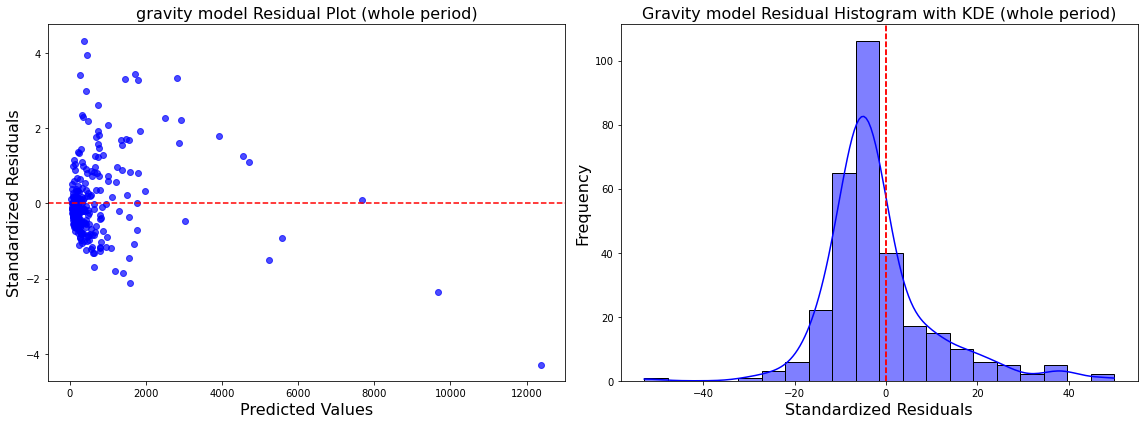

In [117]:


residuals = uncosim.resid_deviance

predictions = uncosim.predict(merged_df)

residuals_std = (residuals - np.mean(residuals)) / np.std(residuals)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(predictions, residuals_std, color='blue', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Predicted Values',fontsize=16)
ax1.set_ylabel('Standardized Residuals',fontsize=16)
ax1.set_title('gravity model Residual Plot (whole period)',fontsize=16)


ax2.hist(residuals, bins=20, color='blue',edgecolor='black', alpha=0.7, density=True)  # Set density to True for normalized histogram
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('Residuals', fontsize=16)
ax2.set_ylabel('Density', fontsize=16)  # Change ylabel to 'Density'
ax2.set_title('Gravity model Residual Frequency Distribution (whole period)', fontsize=16)

# Plot Residual Histogram with Kernel Density Estimation (KDE)
sns.histplot(residuals, bins=20, color='blue', edgecolor='black', ax=ax2,kde=True)
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('Standardized Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Gravity model Residual Histogram with KDE (whole period)', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

### WP-Random Forest Model

In [118]:
# X is an indicator for forecasting purposes and y is the actual flow
X = merged_df[log_x_vars]
y = merged_df["TotalNoIntra"]

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a random forest regression model
rf = RandomForestRegressor(max_features=1.0, random_state=42)

# Create GridSearchCV objects
hyperparameters = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
}

clf = GridSearchCV(rf, hyperparameters)
clf.fit(X_train, y_train)

# Get the best model
best_model = clf.best_estimator_

# Prediction using the best model
predictions = best_model.predict(X_test)

# Output of optimal parameters and corresponding performance indicators
print("Best Parameters: ", clf.best_params_)
print("Best Score: ", -clf.best_score_)

Best Parameters:  {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score:  -0.783424814056181


### Calculate R-square

In [119]:
CalcRSqaured(y_test, predictions)

0.769593290094445

### Calculate RMSE

In [120]:
CalcRMSE(y_test, predictions)

380.898

### Calculate MAE

In [121]:
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 223.54294165220722


In [122]:
num_trees = len(clf.best_estimator_.estimators_)
print("Number of trees in the random forest:", num_trees)

Number of trees in the random forest: 100


### Plotting Random Forest Characteristic Importance Plots, Predictive Scatterplots

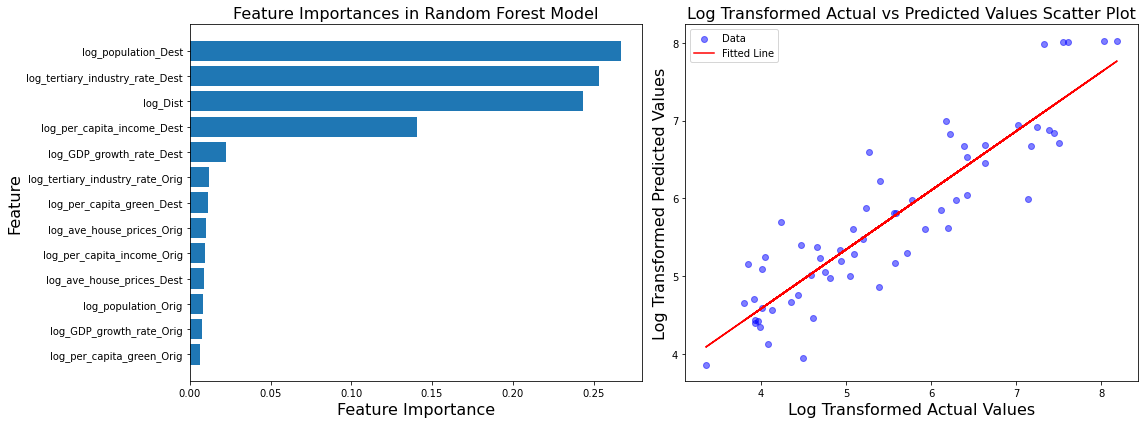

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get feature importances from the best model
feature_importances = clf.best_estimator_.feature_importances_

# Get feature names
feature_names = X.columns

# Create a sorted index based on feature importances
sorted_idx = feature_importances.argsort()

# Plot feature importances
ax1.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
ax1.set_yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
ax1.set_xlabel('Feature Importance',fontsize=16)
ax1.set_ylabel('Feature',fontsize=16)
ax1.set_title('Feature Importances in Random Forest Model',fontsize=16)

# Logarithm of actual and predicted values
y_test_log = np.log(y_test)
predictions_log = np.log(predictions)

# Perform a linear fit
fit = np.polyfit(y_test_log, predictions_log, deg=1)
fit_fn = np.poly1d(fit)

ax2.scatter(y_test_log, predictions_log, color='blue', alpha=0.5, label='Data')
ax2.plot(y_test_log, fit_fn(y_test_log), color='red', label='Fitted Line')
ax2.set_xlabel('Log Transformed Actual Values',fontsize=16)
ax2.set_ylabel('Log Transformed Predicted Values',fontsize=16)
ax2.set_title('Log Transformed Actual vs Predicted Values Scatter Plot',fontsize=16)
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

### Drawing a random forest decision tree with depth 3

In [127]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
import graphviz

# Choose the index of the tree you want to visualize
tree_index = 0  # Replace with the index of the tree you want to visualize

# Get the selected tree
selected_tree = clf.best_estimator_.estimators_[tree_index]

# Create a simplified version of the selected tree with a smaller max_depth
simplified_tree = DecisionTreeRegressor(max_depth=3)  # You can adjust max_depth as needed
simplified_tree.fit(X_train, y_train)  # Fit the simplified tree

# Get the feature names
feature_names = X.columns

# Export the simplified tree to DOT format
dot_data = export_graphviz(simplified_tree, feature_names=feature_names, out_file=None, filled=True, rounded=True, special_characters=True)

# Create a graph from DOT data and display it
graph = graphviz.Source(dot_data)
graph.render(filename=f'simplified_tree_{tree_index}', format='png')  # Save the simplified tree visualization as an image
graph.view()  # Open the simplified tree visualization in your default viewer


NameError: name 'export_graphviz' is not defined

### Plotting Random Forest Residual Distributions

Best Parameters:  {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score:  -0.783424814056181
R-squared: 0.7389532599036168
Mean Squared Error (MSE): 145083.11565539


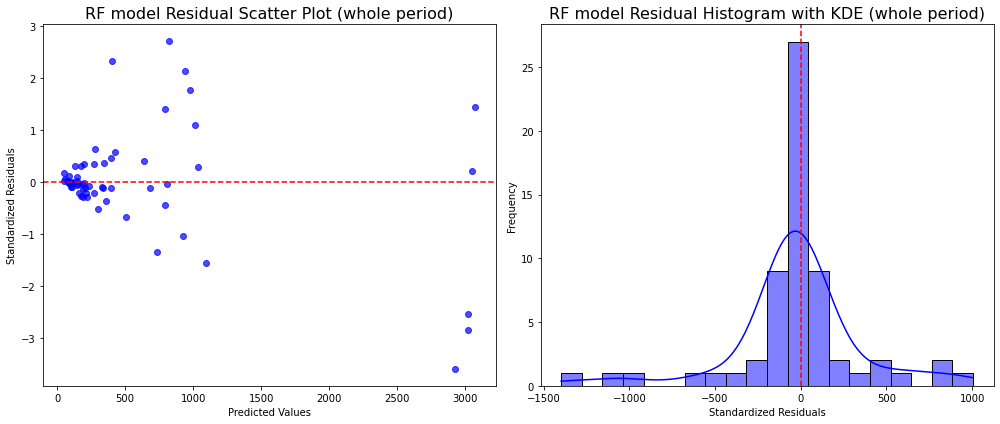

In [128]:
# Prediction using the best model
predictions = best_model.predict(X_test)

# Output of optimal parameters and corresponding performance indicators
print("Best Parameters: ", clf.best_params_)
print("Best Score: ", -clf.best_score_)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

# Plot Residual Scatter Plot and Histogram
residuals = y_test - predictions
residuals_std = (residuals - np.mean(residuals)) / np.std(residuals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Residual Scatter Plot
ax1.scatter(predictions, residuals_std, color='blue', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Standardized Residuals')
ax1.set_title('RF model Residual Scatter Plot (whole period)', fontsize=16)

# Plot Residual Histogram with Kernel Density Estimation (KDE)
sns.histplot(residuals, bins=20, color='blue', edgecolor='black', ax=ax2,kde=True)
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('Standardized Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('RF model Residual Histogram with KDE (whole period)', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()
plt.show()

### WP - XGBoost model

In [496]:
X = merged_df[log_x_vars]
y = merged_df["TotalNoIntra"]

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# values of max_depth and min_samples_split
hyperparameters = {
    'max_depth': [2,4,6,8],
    'min_child_weight': [2,4,6,8],
    'learning_rate':[0,1,0,3,0.5,0.7]
}

randomState_xgb = 42
xgb = XGBRegressor(random_state=randomState_xgb)


# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(X_train,  y_train)

best_model_xgb = gscv_xgb.best_estimator_

predictions_xgb = best_model_xgb.predict(X_test)
print("Best Parameters: ", gscv_xgb.best_params_)
print("Best Score: ", -gscv_xgb.best_score_)

Best Parameters:  {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 8}
Best Score:  -0.8503809284894632


307.421

### XGBoost -R-square

In [697]:
CalcRSqaured(y_test, predictions_xgb)

0.836314701392439

### XGBoost -RMSE

In [541]:
CalcRMSE(y_test, predictions_xgb)

307.421

### XGBoost -MAE

In [700]:
mae = mean_absolute_error(y_test, predictions_xgb)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 199.5529918438388


### Plotting the XGBoost residual distribution

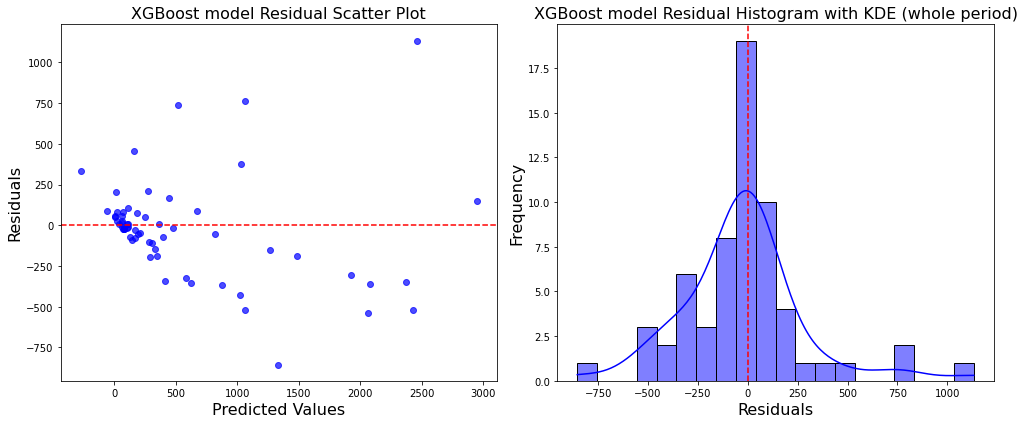

Root Mean Squared Error (RMSE): 307.4212


In [507]:
# Calculate residuals
residuals_xgb = y_test - predictions_xgb

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Residual scatter plot
ax1.scatter(predictions_xgb, residuals_xgb, color='blue', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Predicted Values', fontsize=16)
ax1.set_ylabel('Residuals', fontsize=16)
ax1.set_title('XGBoost model Residual Scatter Plot', fontsize=16)

# Residual histogram
sns.histplot(residuals_xgb, bins=20, kde=True, color='blue', ax=ax2)
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('Residuals', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)
ax2.set_title('XGBoost model Residual Histogram with KDE (whole period)', fontsize=16)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()

# Calculate and print RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse_xgb))

### Plotting XGBoost Feature Importance Plots, Predictive Scatterplots

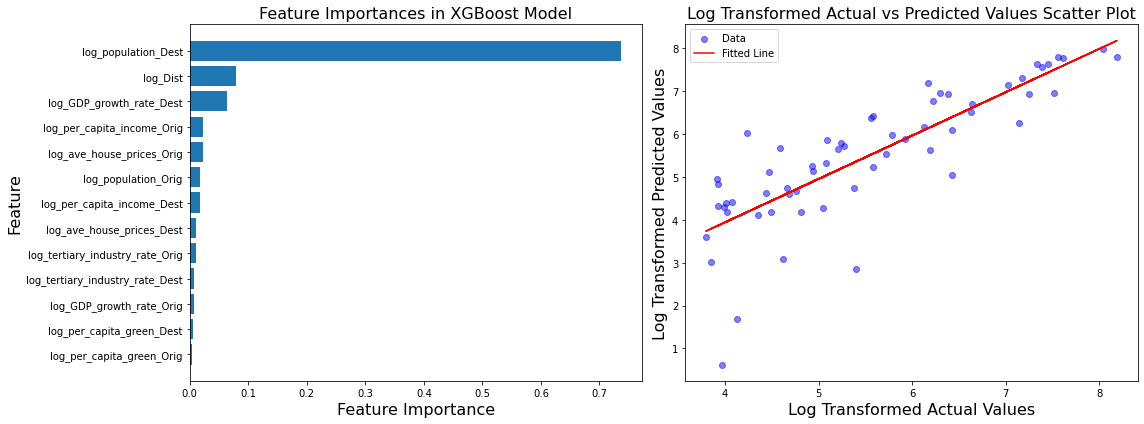

In [701]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get feature importances from the best model
feature_importances = gscv_xgb.best_estimator_.feature_importances_

# Get feature names
feature_names = X.columns

# Create a sorted index based on feature importances
sorted_idx = feature_importances.argsort()

# Plot feature importances
ax1.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
ax1.set_yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
ax1.set_xlabel('Feature Importance',fontsize=16)
ax1.set_ylabel('Feature',fontsize=16)
ax1.set_title('Feature Importances in XGBoost Model',fontsize=16)

# Find the index of a non-negative number
non_negative_idx = predictions_xgb >= 0

# Filtering data using non-negative indexes
y_test_non_negative = y_test[non_negative_idx]
predictions_non_negative = predictions_xgb[non_negative_idx]

# Logarithm of actual and predicted values
y_test_log = np.log(y_test_non_negative)
predictions_log = np.log(predictions_non_negative)

# Perform a linear fit
fit = np.polyfit(y_test_log, predictions_log, deg=1)
fit_fn = np.poly1d(fit)

# Plotting Scatter Plots
ax2.scatter(y_test_log, predictions_log, color='blue', alpha=0.5, label='Data')
ax2.plot(y_test_log, fit_fn(y_test_log), color='red', label='Fitted Line')
ax2.set_xlabel('Log Transformed Actual Values', fontsize=16)
ax2.set_ylabel('Log Transformed Predicted Values', fontsize=16)
ax2.set_title('Log Transformed Actual vs Predicted Values Scatter Plot', fontsize=16)
ax2.legend()


plt.tight_layout()

plt.show()

### Visualizing the second decision tree of XGBoost

<Figure size 3000x2400 with 0 Axes>

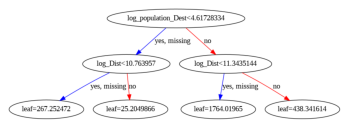

In [569]:
booster = best_model_xgb.get_booster()
plt.figure(figsize=(10, 8), dpi=300)
xgboost.plot_tree(booster, num_trees=1)
plt.savefig('tree_1.png', format='png', dpi=300, bbox_inches='tight')

In [536]:
num_trees = best_model_xgb.n_estimators
print("Total number of trees in the XGBoost model:", num_trees)

Total number of trees in the XGBoost model: 100
